In [1]:
import sys
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
from lifelines.statistics import multivariate_logrank_test

from scipy import stats
from scipy.stats import chi2_contingency

In [2]:
import mmrf_data_loader 

In [3]:
patient_list, patients_mask, event_duration, censorlist = mmrf_data_loader.load_MMRF_clinical_data()

659
10
659


In [4]:
data_all = scipy.io.loadmat('data/data_may4_2022.mat')
rna_data = data_all['rna_data']
rna_data = rna_data[:, patients_mask]
for n in range(0, rna_data.shape[0]): 
    for m in range(0, rna_data.shape[1]): 
        rna_data[n, m] = rna_data[n, m][0][0]
wee1_data = rna_data[8152, :]

In [5]:
gene_list = data_all['gene_list']
gene_list = [x.strip(' ') for x in gene_list]
gene_list = np.array(gene_list) 

In [6]:
WEE1_low_mask = wee1_data < np.percentile(wee1_data, 33)
WEE1_high_mask = wee1_data > np.percentile(wee1_data, 66)
WEE1_mask = WEE1_low_mask + WEE1_high_mask
wee1_labels = 1*WEE1_low_mask + 2*WEE1_high_mask

In [7]:
event_duration = event_duration[WEE1_mask]
censorlist = censorlist[WEE1_mask]
wee1_labels = wee1_labels[WEE1_mask]

In [8]:
patient_list = patient_list[WEE1_mask]

In [9]:
clinical_data_df = pd.read_csv('data/km_clinical_data_669.csv')
clinical_data_df = clinical_data_df[clinical_data_df['subjectIDlist'].isin(patient_list)]
clinical_data_df = clinical_data_df.reset_index()

In [10]:
secondary_dataset_df = pd.read_excel('data/MMRF_clin_IA13_to_Anish.xlsx')
columns = ['sample', 'HRD', 't_MMSET', 't_CCND1', 'any_MAF',\
           't_MYC', 'chromothripsis_code', 'APOBEC_code',\
           'delTP53', 'gain1q21']
shorter_id_list = [] 
for id in patient_list: 
    shorter_id_list.append(id[0:14])

secondary_dataset_df = secondary_dataset_df[secondary_dataset_df['sample'].isin(shorter_id_list)]
secondary_dataset_df = secondary_dataset_df.reset_index()
secondary_dataset_df = secondary_dataset_df[columns]

In [11]:
# Plot KM curves of HRD

In [12]:
short_patient_list = [] 
for id in patient_list: 
    short_patient_list.append(id[0:14])

In [13]:
wee1_hi_lo_df = pd.DataFrame({'patient_list':patient_list,\
                              'short_patient_list':short_patient_list, \
                            'event_duration':event_duration, 'censorlist':censorlist, \
                             'wee1_labels':wee1_labels})

In [14]:
wee1_hi_lo_df = wee1_hi_lo_df[wee1_hi_lo_df['short_patient_list'].isin(secondary_dataset_df['sample'].values)]

In [15]:
wee1_hi_lo_df = wee1_hi_lo_df.reset_index()

In [16]:
wee1_hi_lo_df = pd.concat([wee1_hi_lo_df, secondary_dataset_df], axis=1, join='outer')

In [17]:
wee1_hi_lo_df['sample'].equals(wee1_hi_lo_df['short_patient_list'])

True

In [18]:
wee1_hi_lo_df = wee1_hi_lo_df[['patient_list', 'short_patient_list', 'event_duration',\
       'censorlist', 'wee1_labels', 'HRD', 't_MMSET', 't_CCND1',\
               'any_MAF', 't_MYC', 'chromothripsis_code', \
       'APOBEC_code', 'delTP53', 'gain1q21']]

In [19]:
wee1_hi_lo_df.columns

Index(['patient_list', 'short_patient_list', 'event_duration', 'censorlist',
       'wee1_labels', 'HRD', 't_MMSET', 't_CCND1', 'any_MAF', 't_MYC',
       'chromothripsis_code', 'APOBEC_code', 'delTP53', 'gain1q21'],
      dtype='object')

In [20]:
wee1_hi_lo_df['gain1q21'].value_counts()

0.0    246
1.0     93
2.0     20
Name: gain1q21, dtype: int64

In [21]:
wee1_hi_lo_df.columns

Index(['patient_list', 'short_patient_list', 'event_duration', 'censorlist',
       'wee1_labels', 'HRD', 't_MMSET', 't_CCND1', 'any_MAF', 't_MYC',
       'chromothripsis_code', 'APOBEC_code', 'delTP53', 'gain1q21'],
      dtype='object')

In [22]:
wee1_hi_lo_df[wee1_hi_lo_df['APOBEC_code']>0].shape

(31, 14)

In [23]:
wee1_hi_lo_df

,patient_list,short_patient_list,event_duration,censorlist,wee1_labels,HRD,t_MMSET,t_CCND1,any_MAF,t_MYC,chromothripsis_code,APOBEC_code,delTP53,gain1q21
0,MMRF_1029_1_BM_CD138pos,MMRF_1029_1_BM,2.726027,0,1,1.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
1,MMRF_1030_1_BM_CD138pos,MMRF_1030_1_BM,5.435616,1,1,1.0,0.0,0.0,0,1.0,0,0.0,0.0,0.0
2,MMRF_1031_1_BM_CD138pos,MMRF_1031_1_BM,3.641096,1,2,1.0,0.0,0.0,0,0.0,0,0.0,0.0,1.0
3,MMRF_1033_1_BM_CD138pos,MMRF_1033_1_BM,0.597260,1,1,NaN,0.0,0.0,0,0.0,0,1.0,NaN,NaN
4,MMRF_1037_1_BM_CD138pos,MMRF_1037_1_BM,0.263014,0,1,1.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,MMRF_2745_1_BM_CD138pos,MMRF_2745_1_BM,0.002740,0,1,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
381,MMRF_2746_1_BM_CD138pos,MMRF_2746_1_BM,0.424658,0,2,0.0,1.0,0.0,0,0.0,0,0.0,0.0,1.0
382,MMRF_2750_1_BM_CD138pos,MMRF_2750_1_BM,0.904110,0,1,0.0,0.0,1.0,0,0.0,0,0.0,0.0,0.0
383,MMRF_2754_1_BM_CD138pos,MMRF_2754_1_BM,0.021918,1,2,0.0,0.0,1.0,0,0.0,0,0.0,0.0,1.0


-------------
HRD
1 4.03288  years
2 2.19452  years

-------------
t_MMSET
1 2.82466  years
2 1.70959  years

-------------
t_CCND1
1 inf  years
2 3.09589  years

-------------
any_MAF
1 inf  years
2 2.38082  years

-------------
t_MYC
1 3.43014  years
2 1.30959  years

-------------
chromothripsis_code
1 3.73699  years
2 1.30959  years

-------------
APOBEC_code
1 3.88219  years
2 1.50411  years

-------------
delTP53
1 inf  years
2 1.21918  years



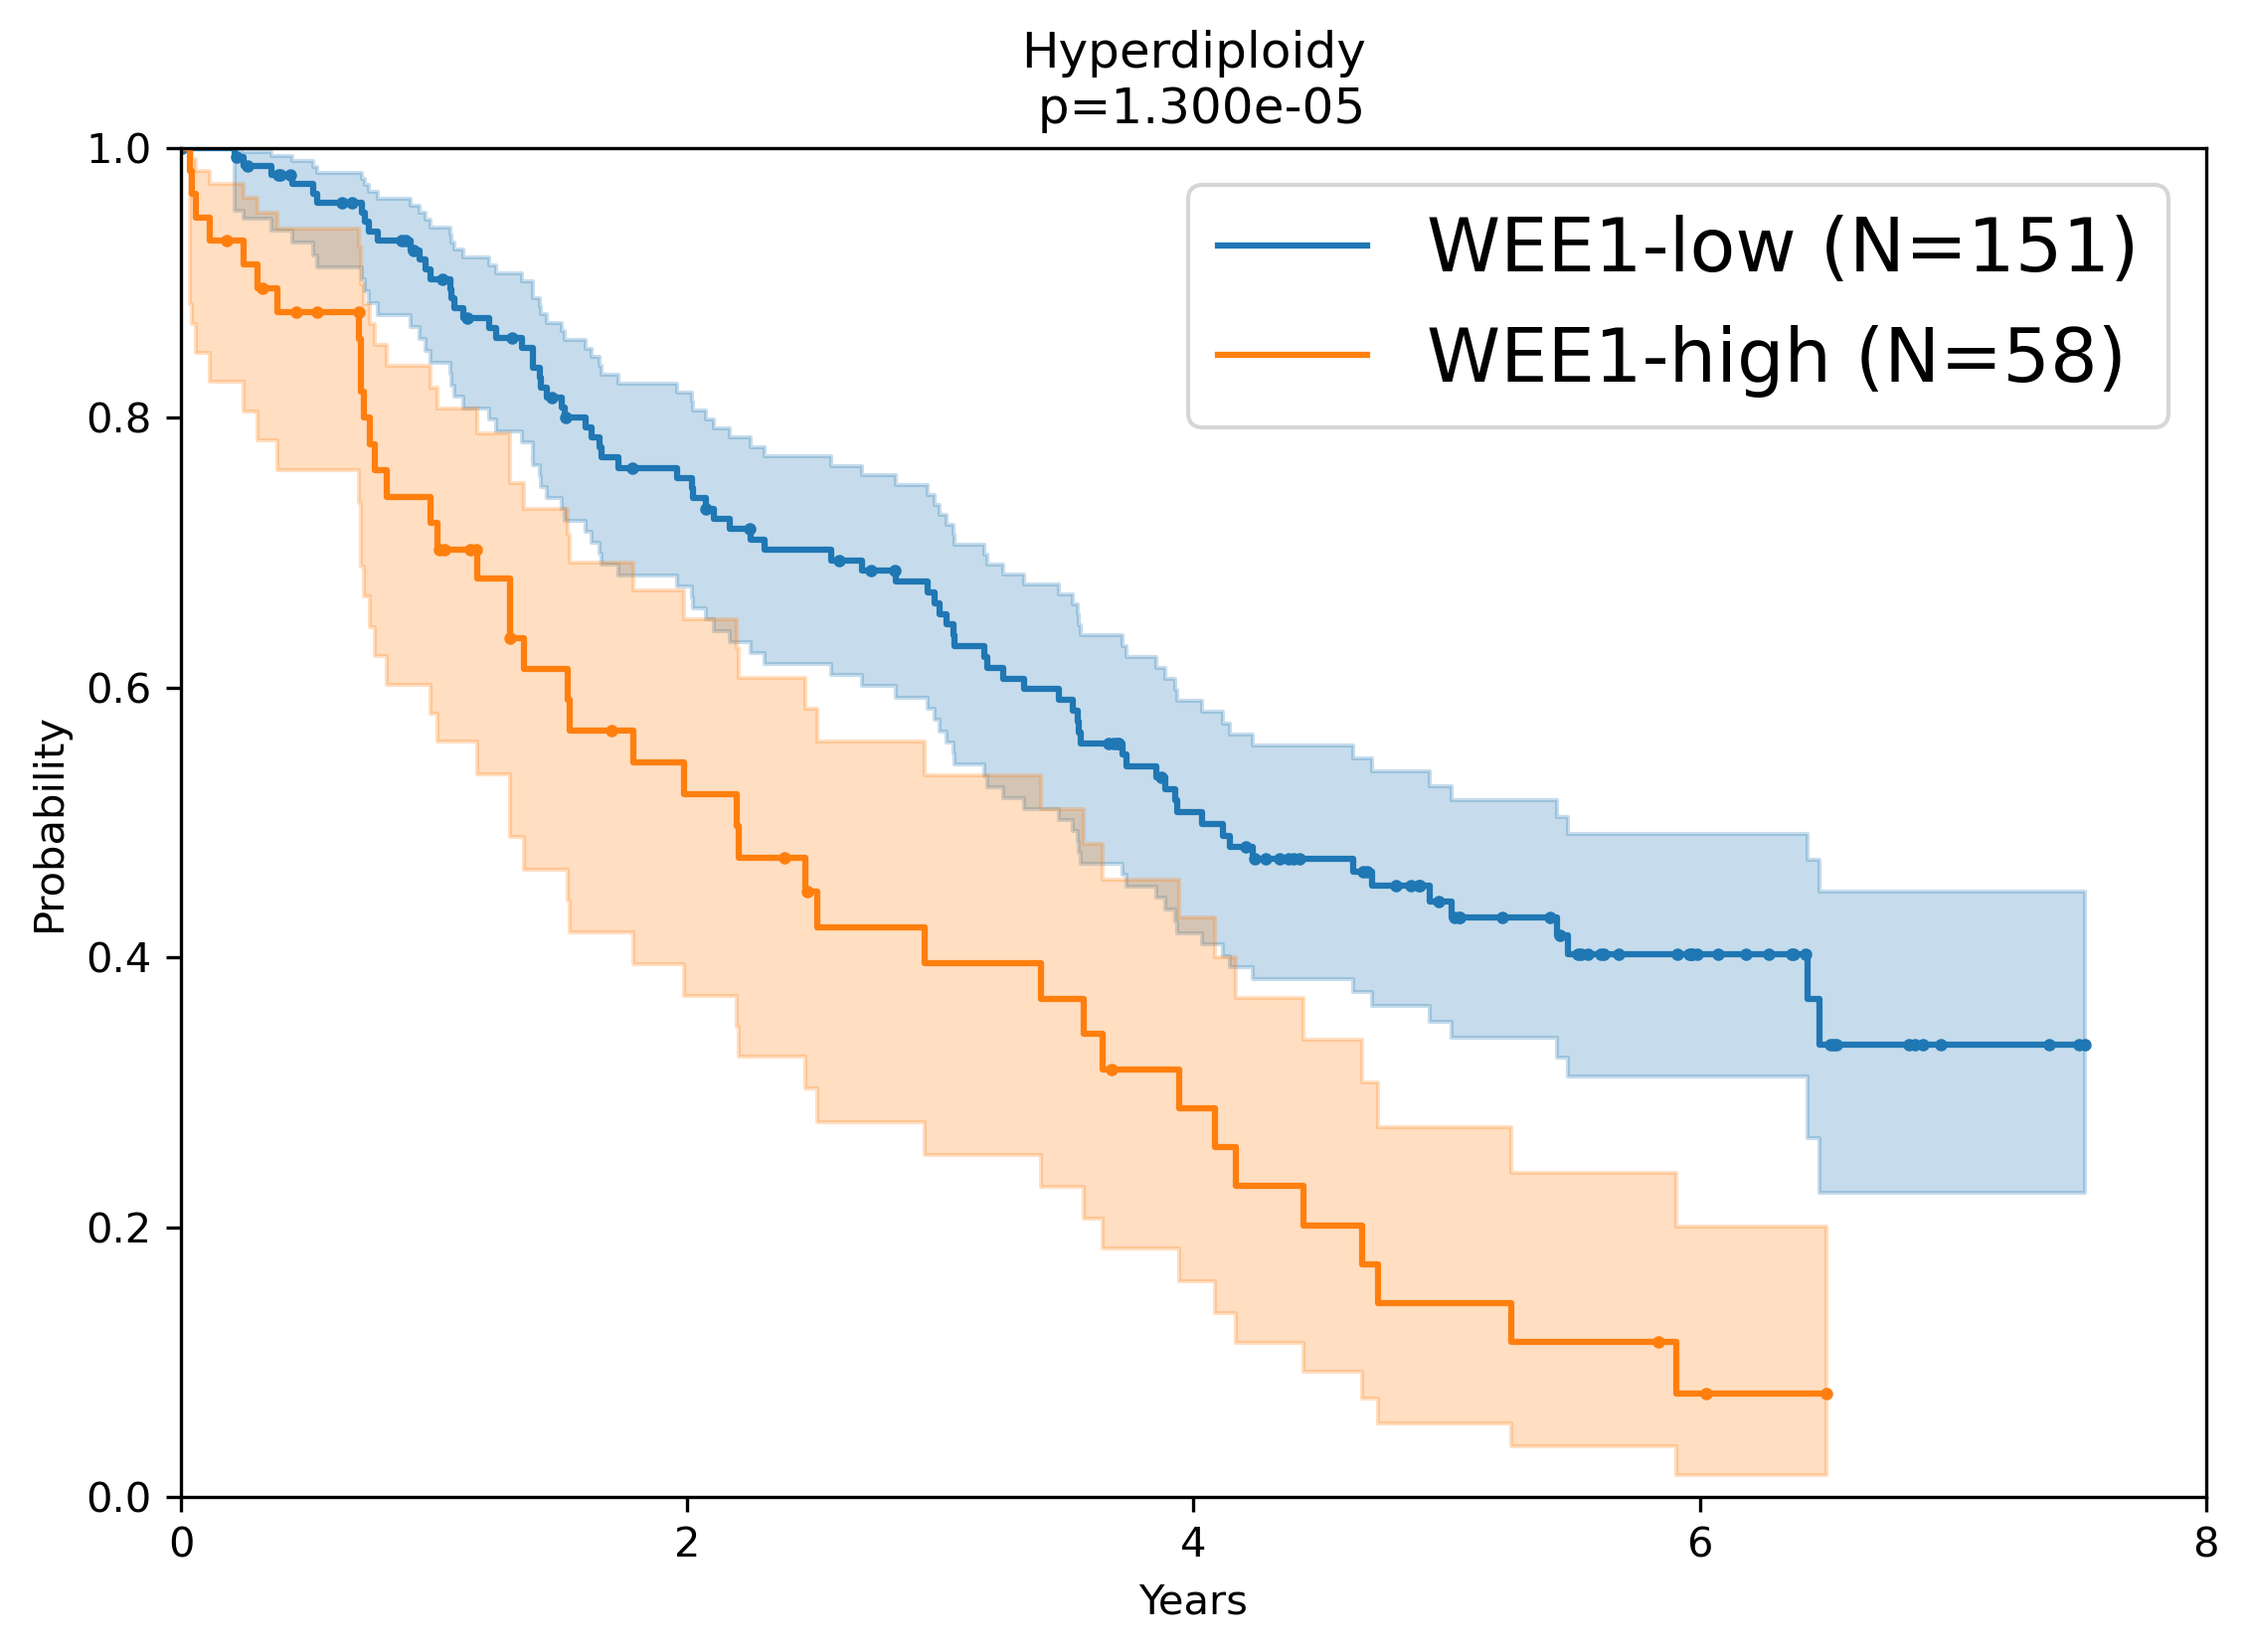

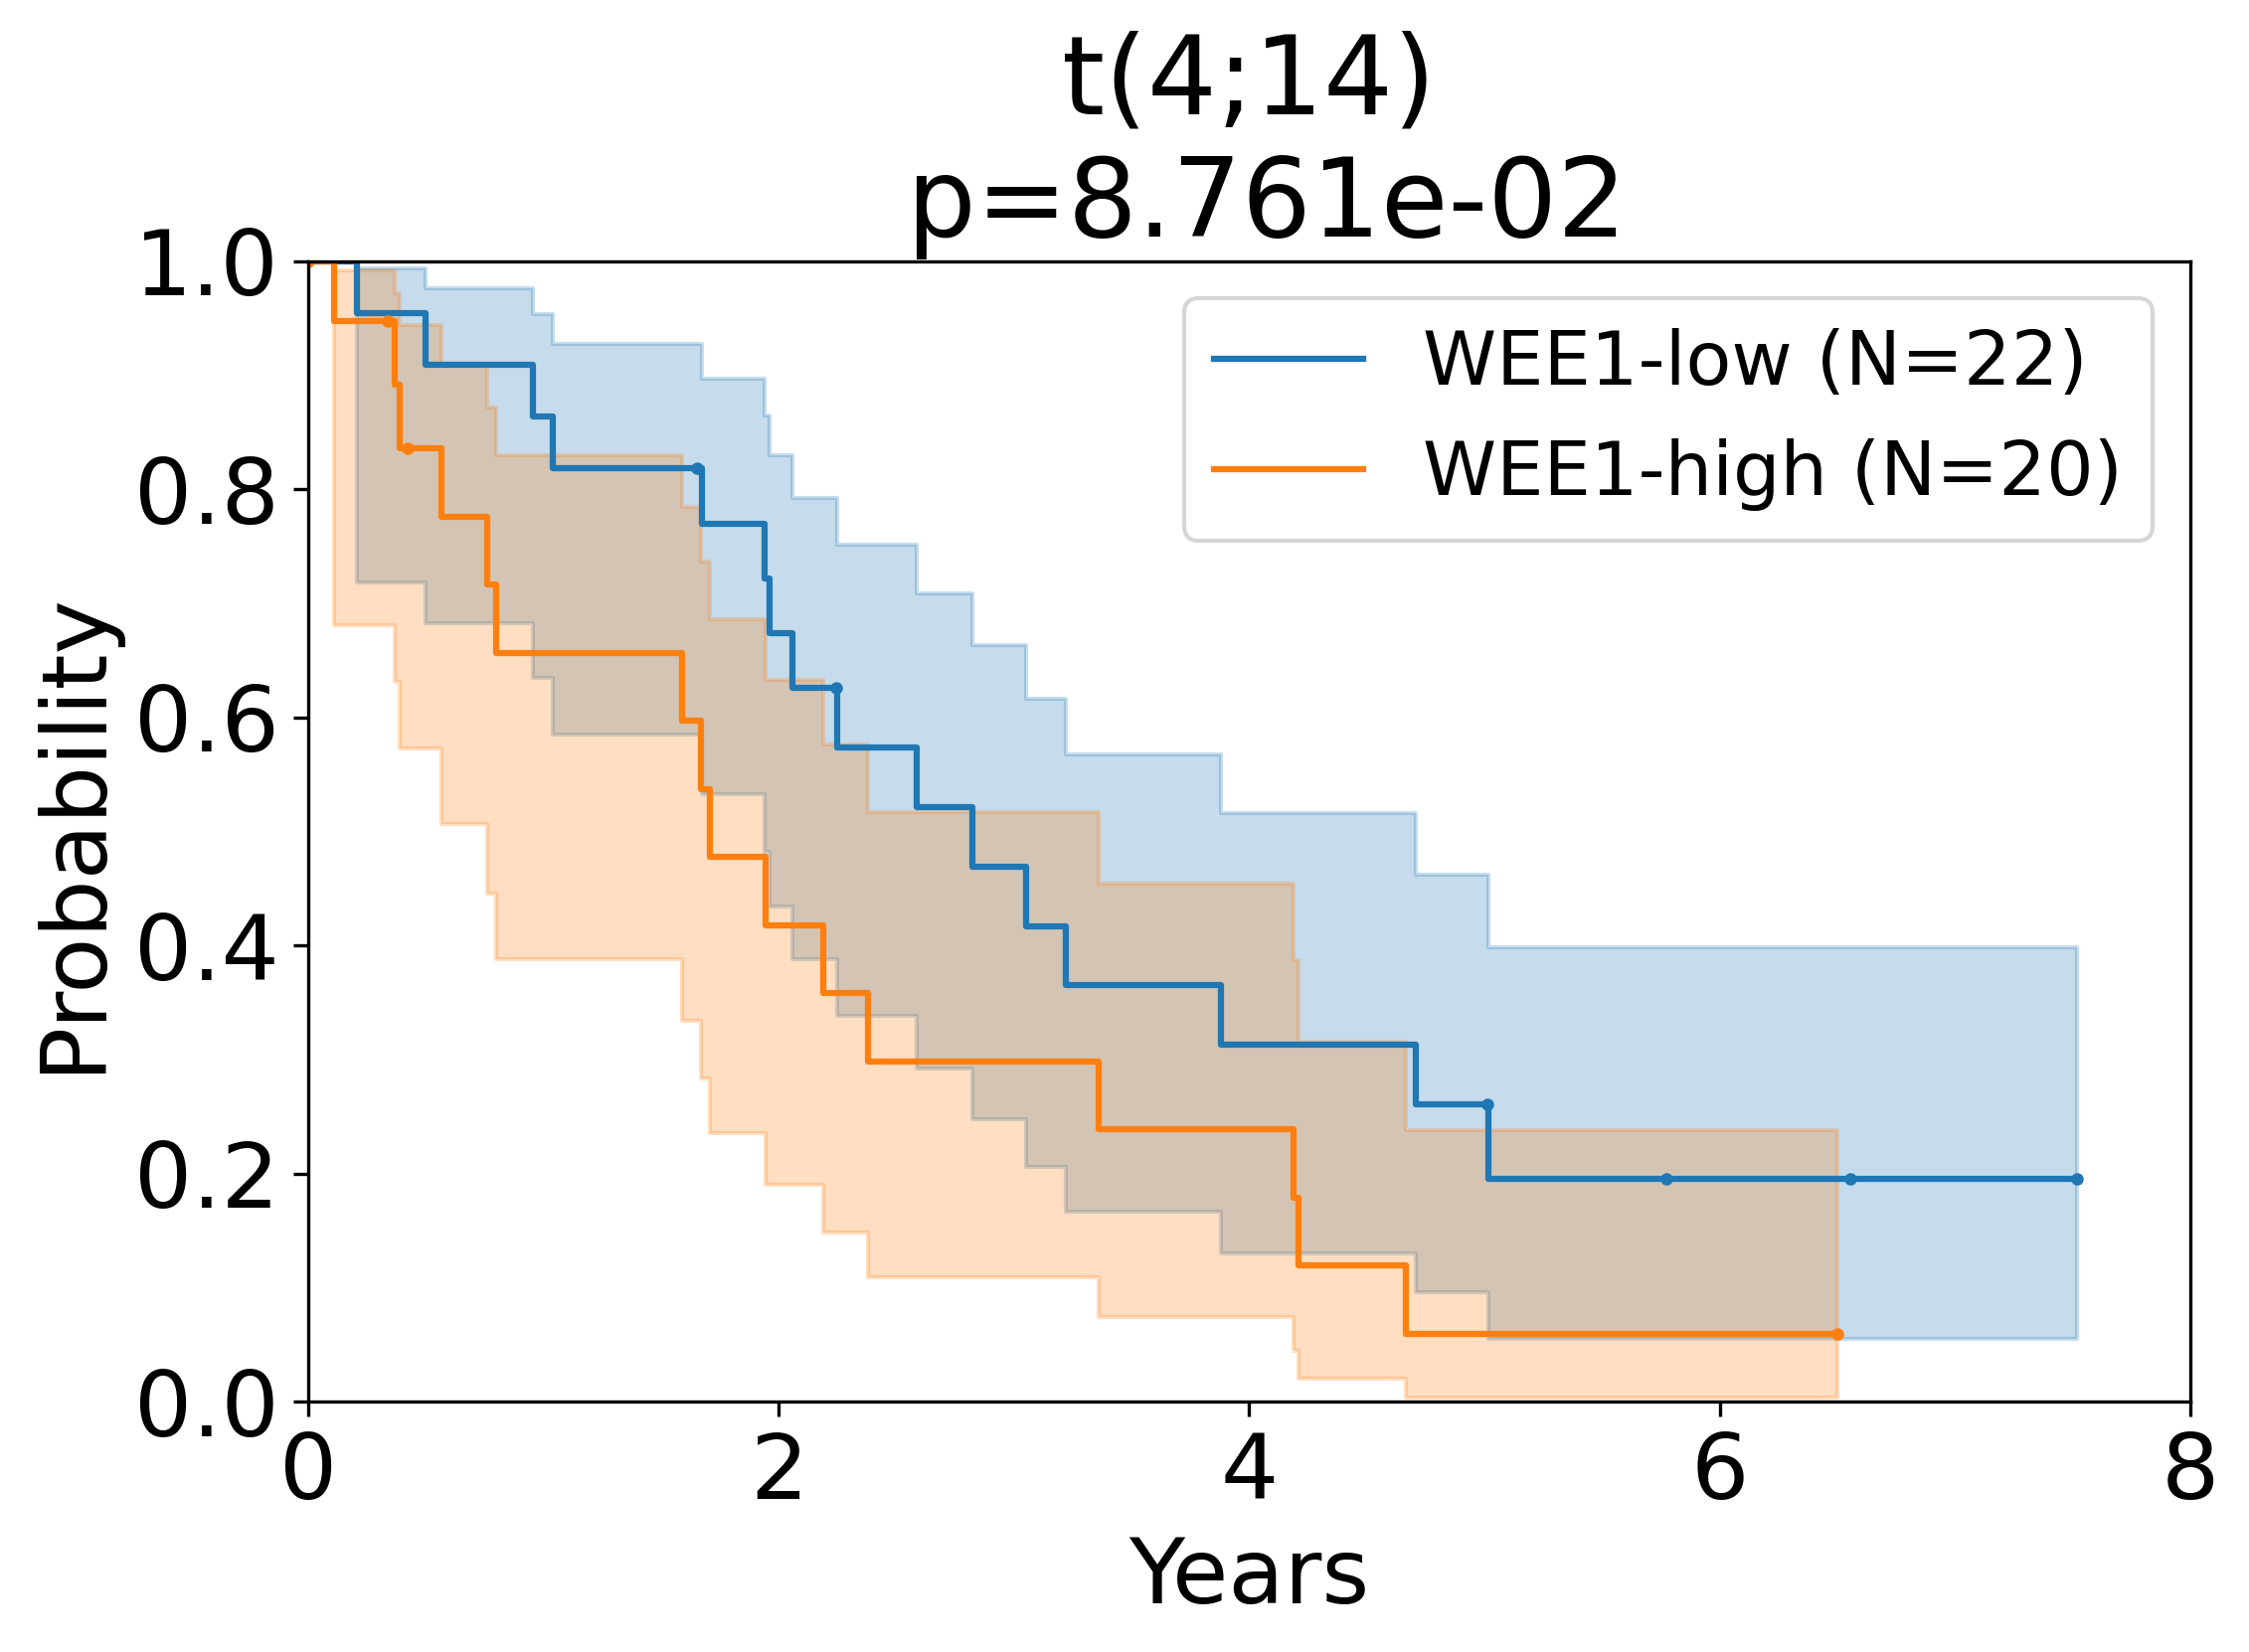

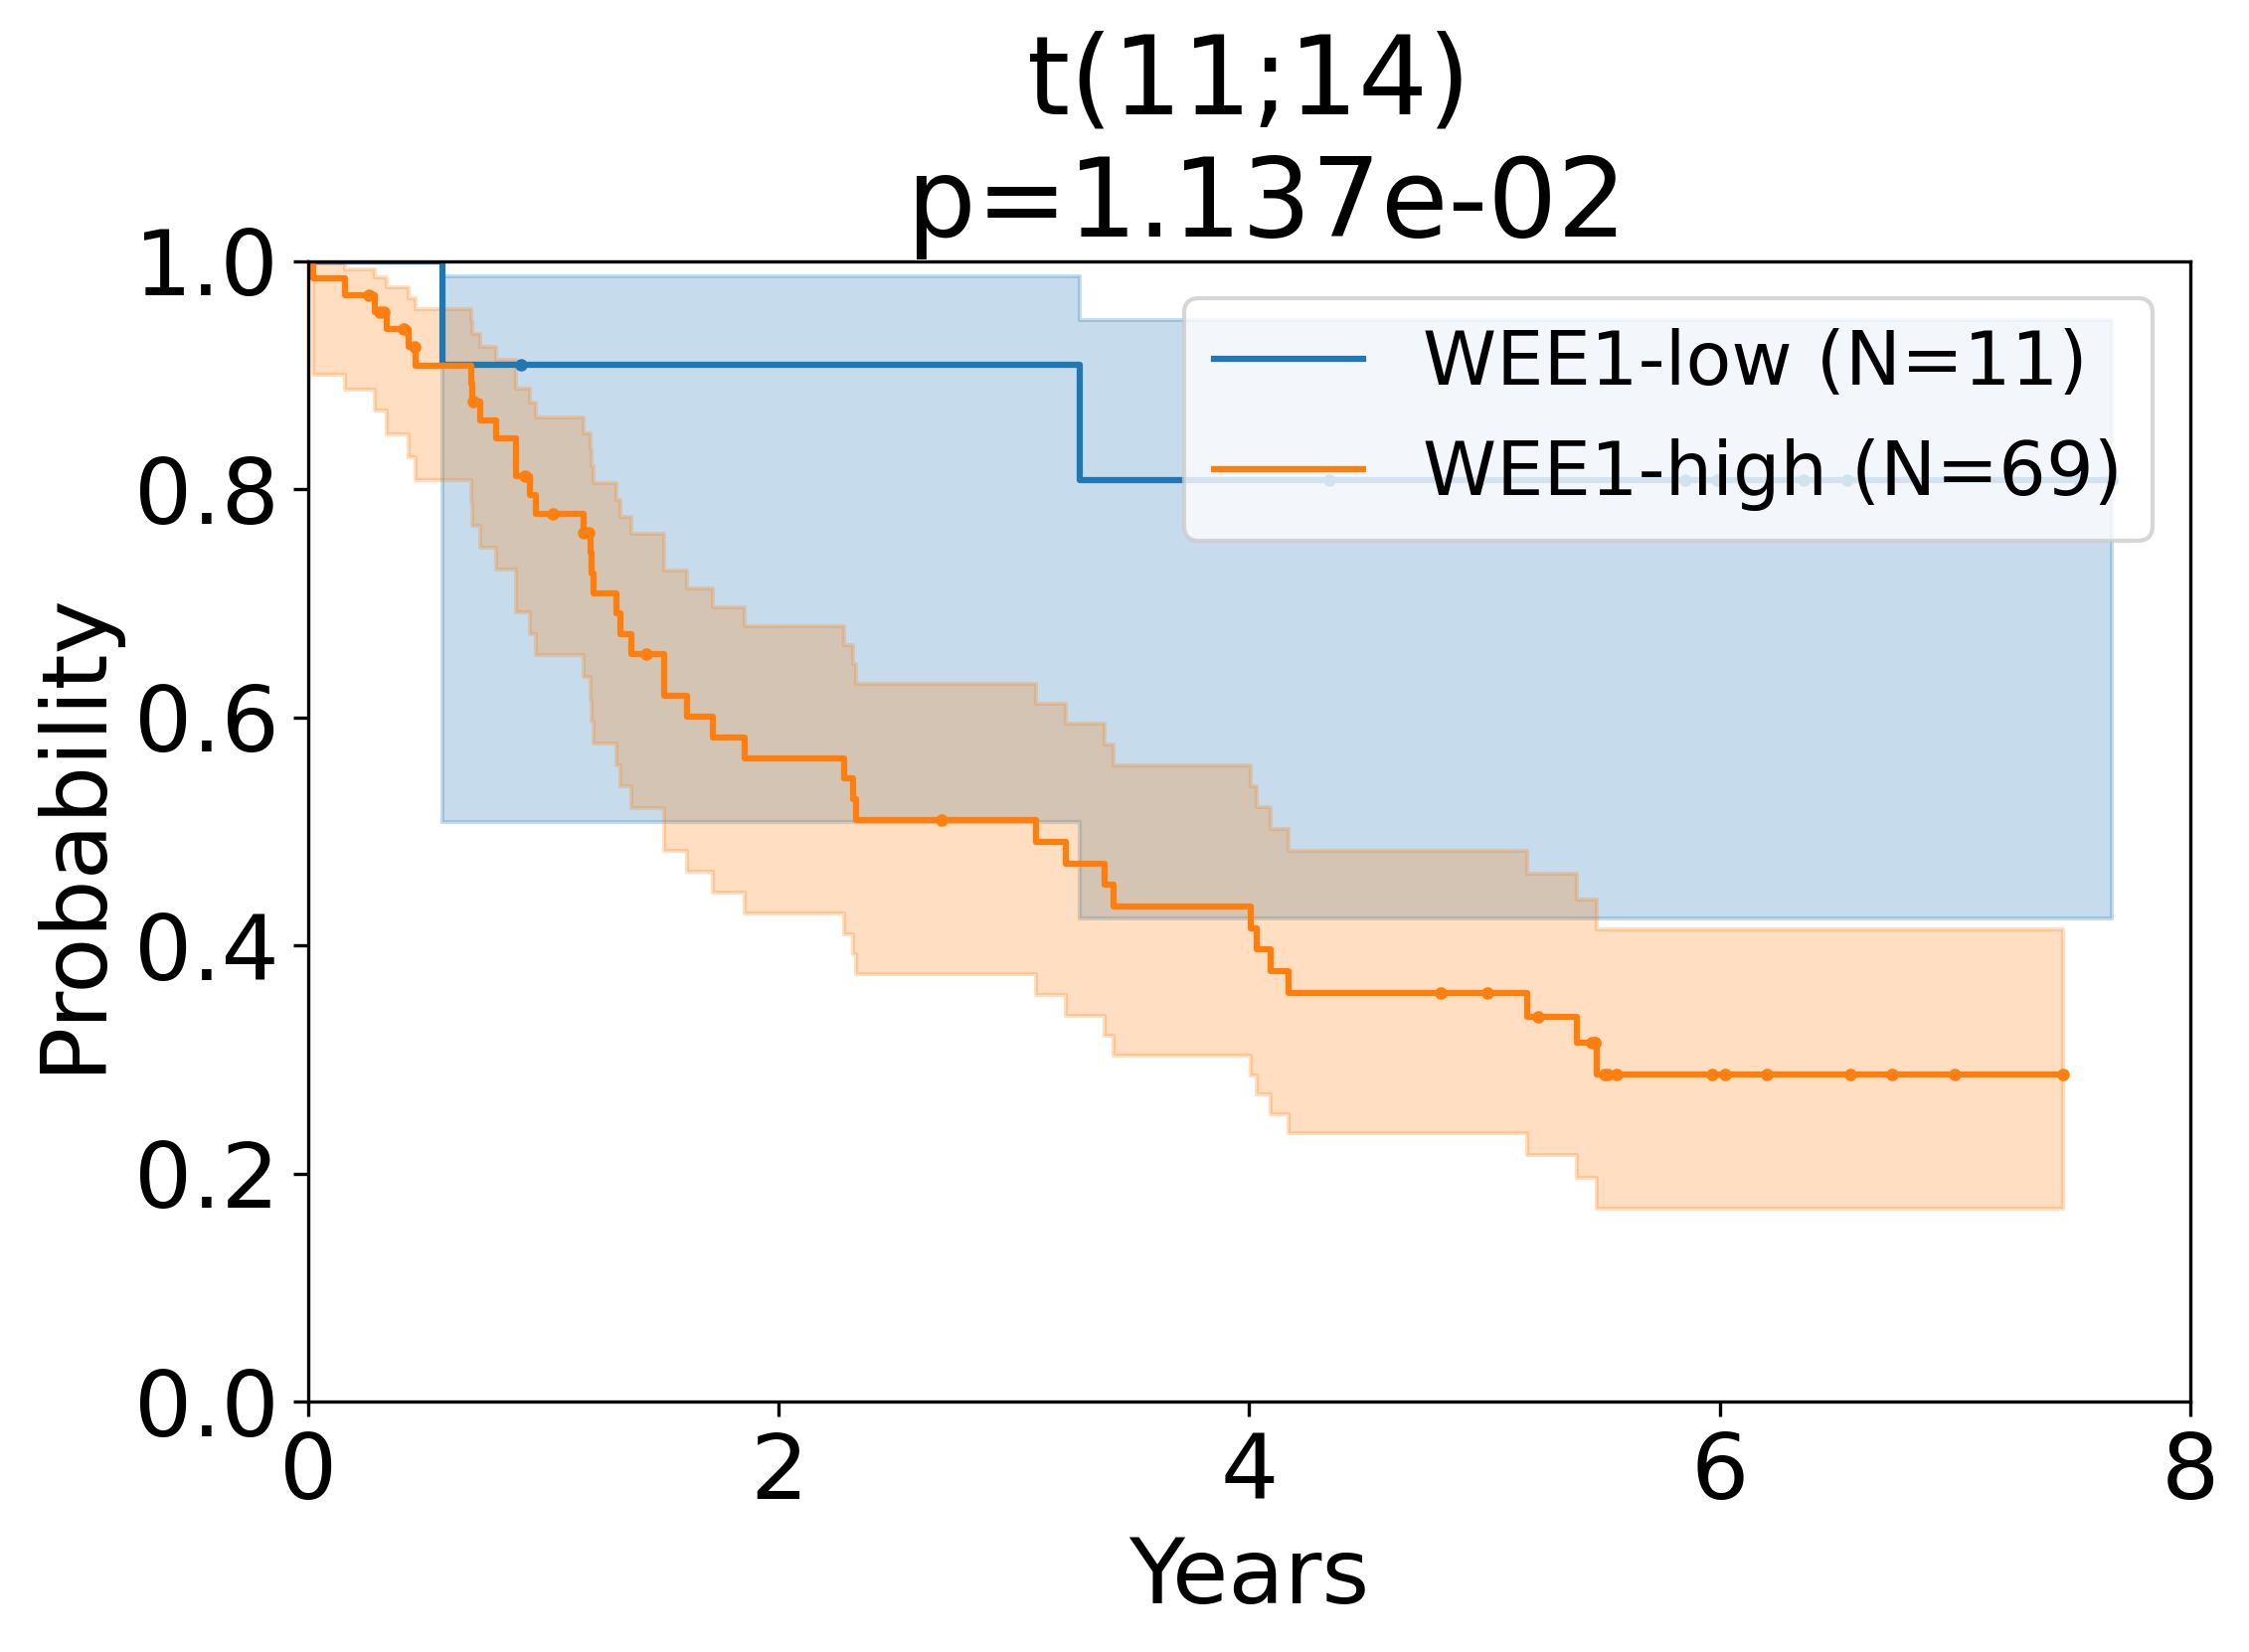

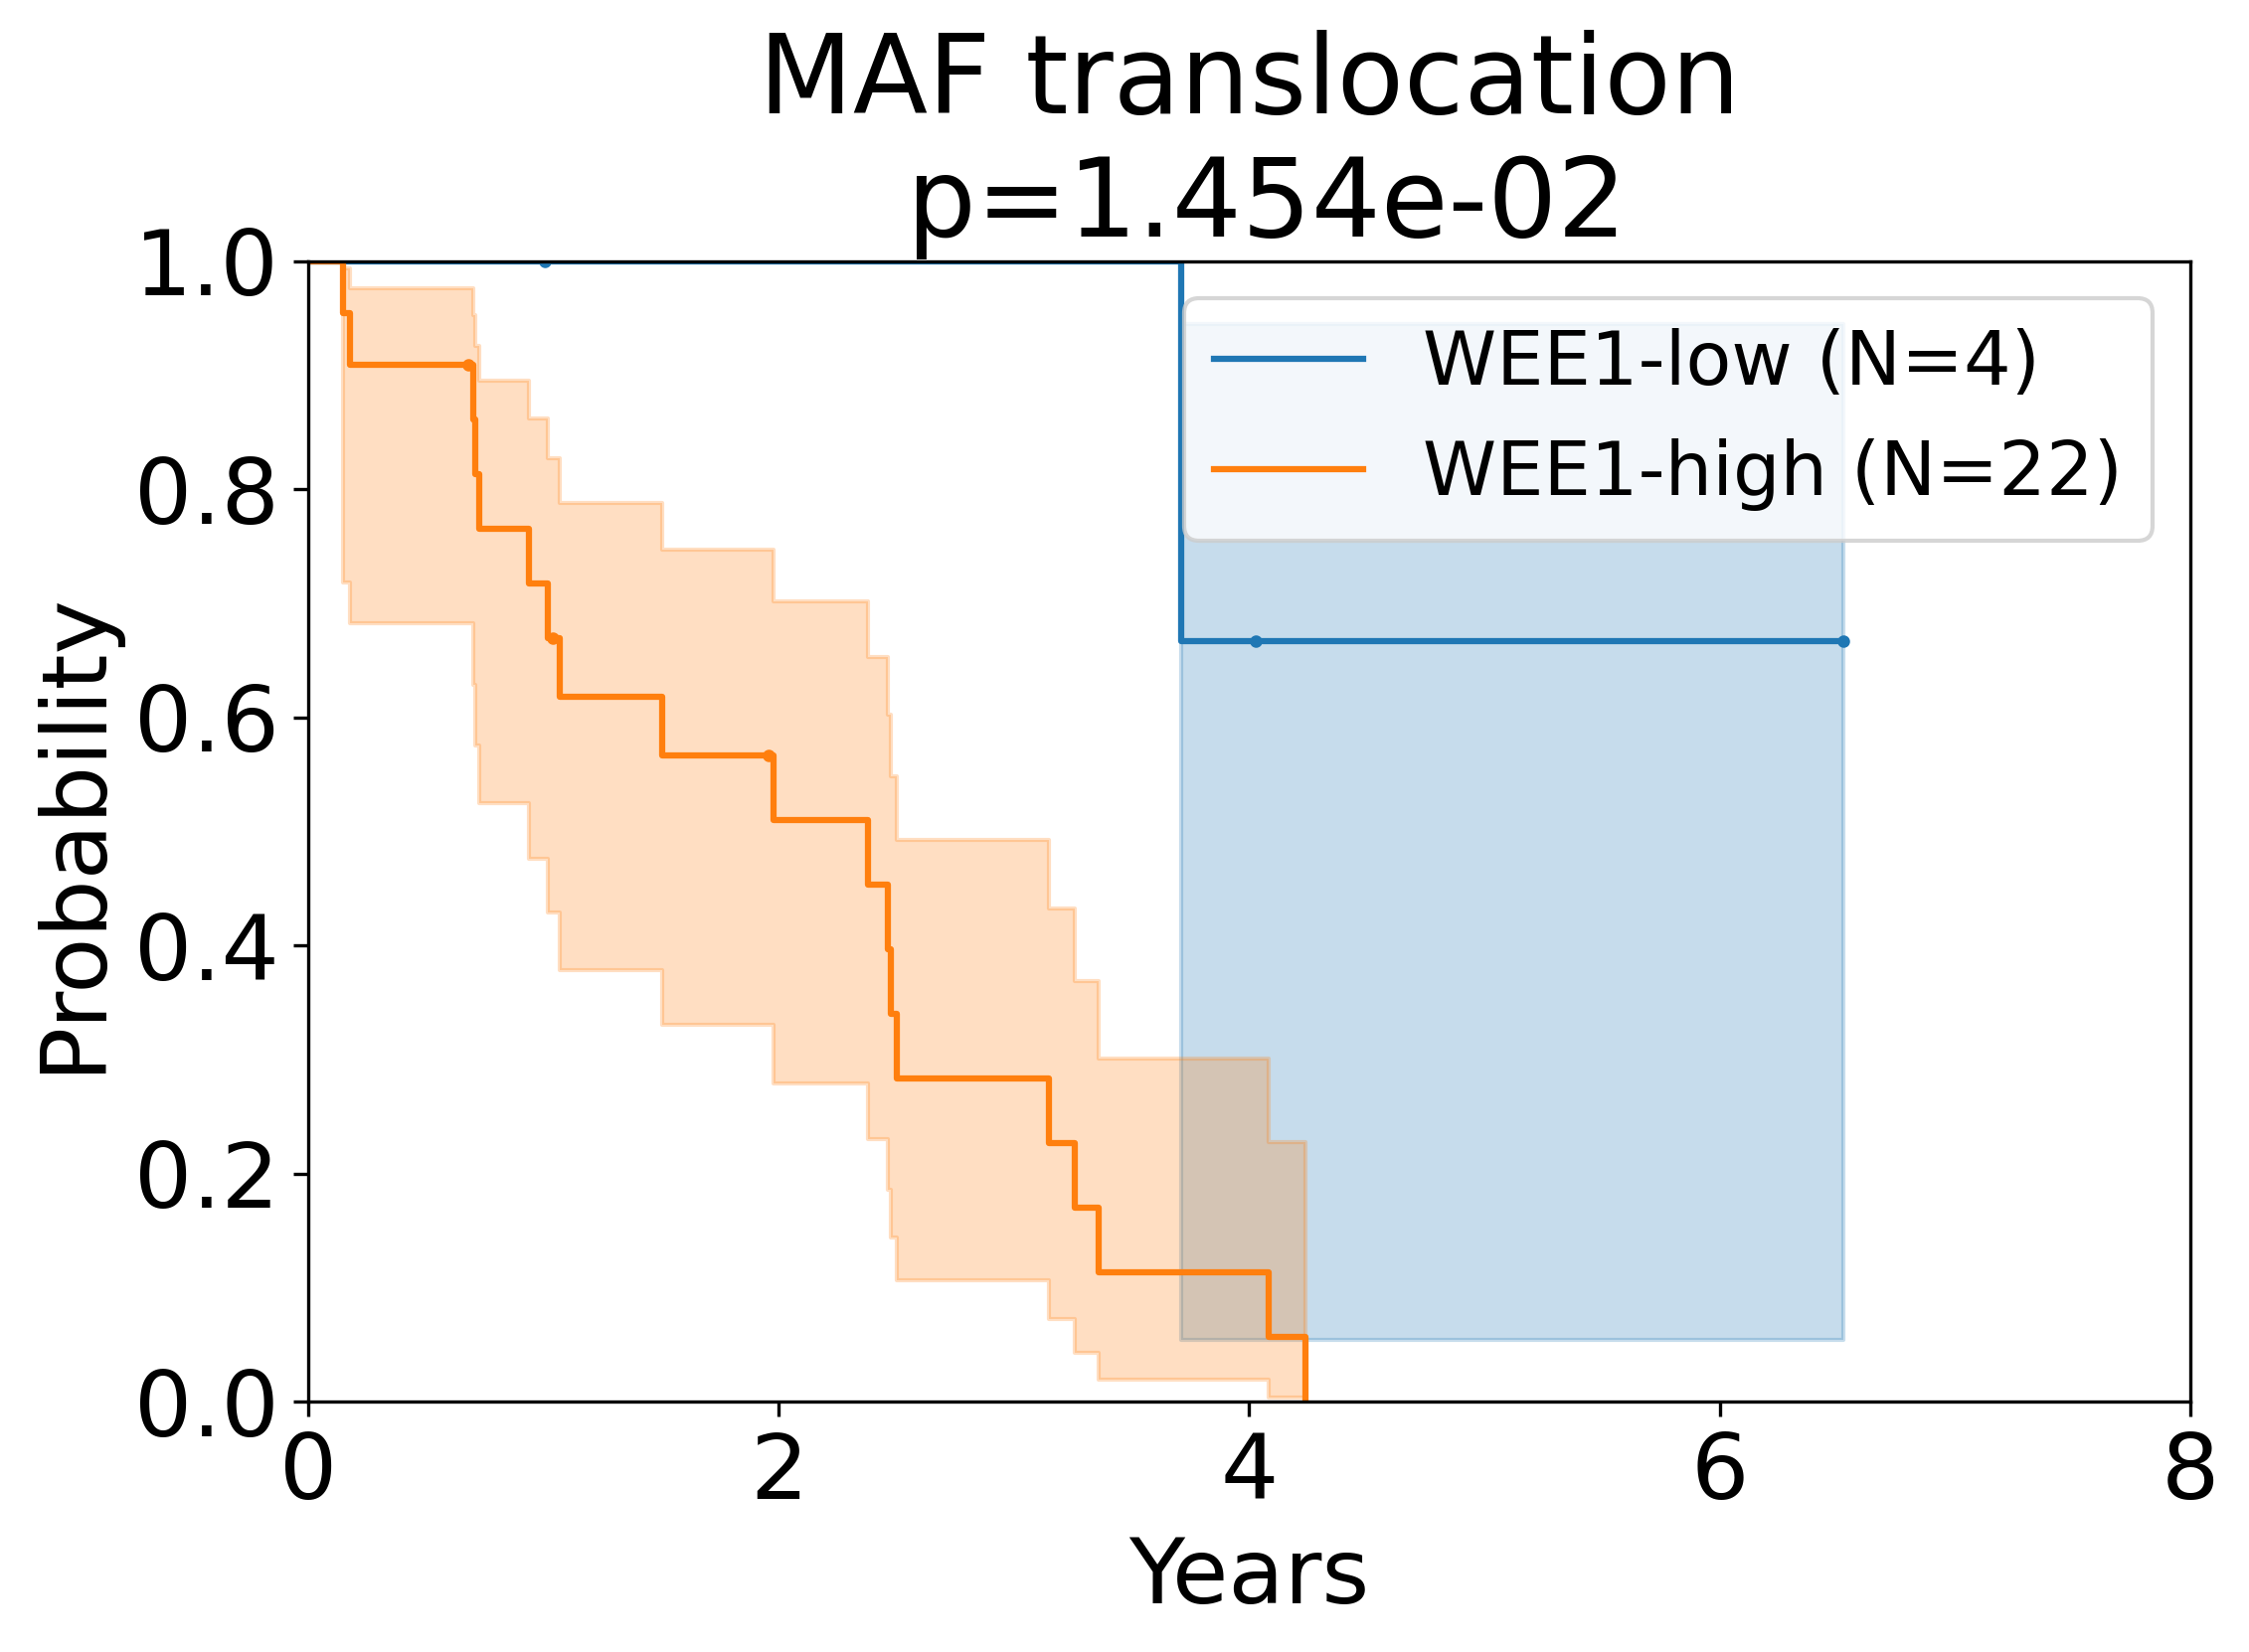

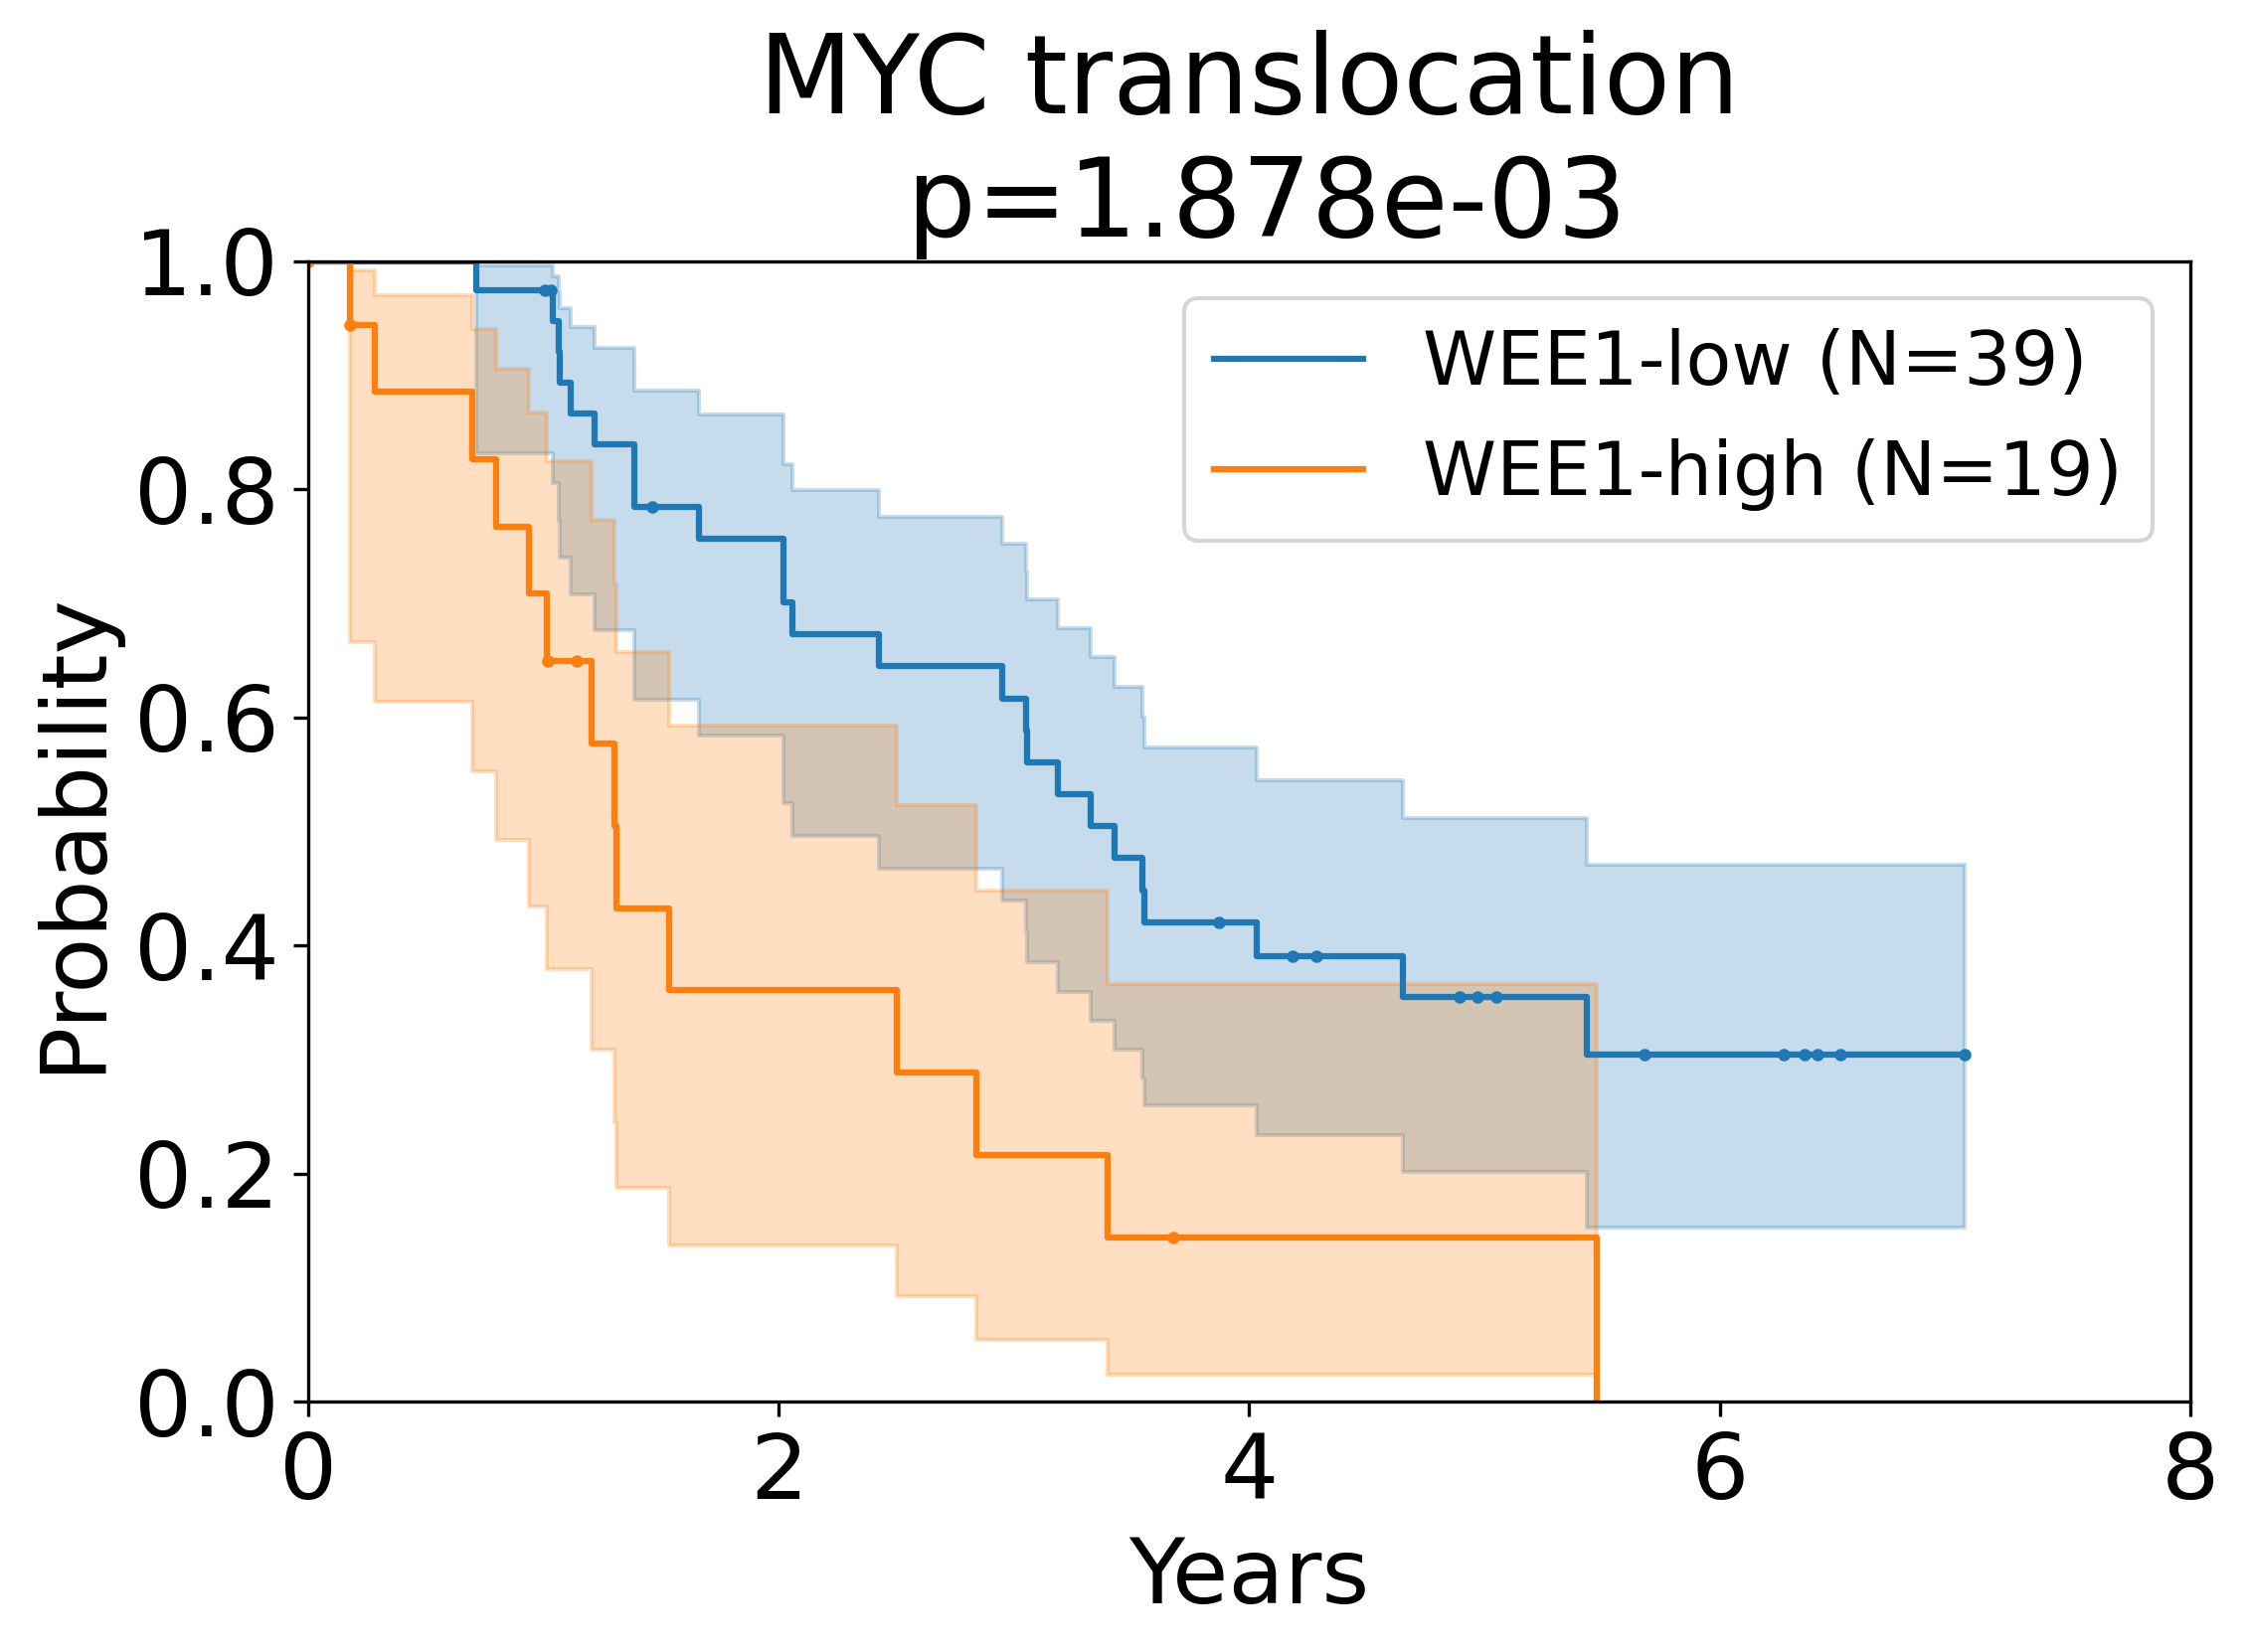

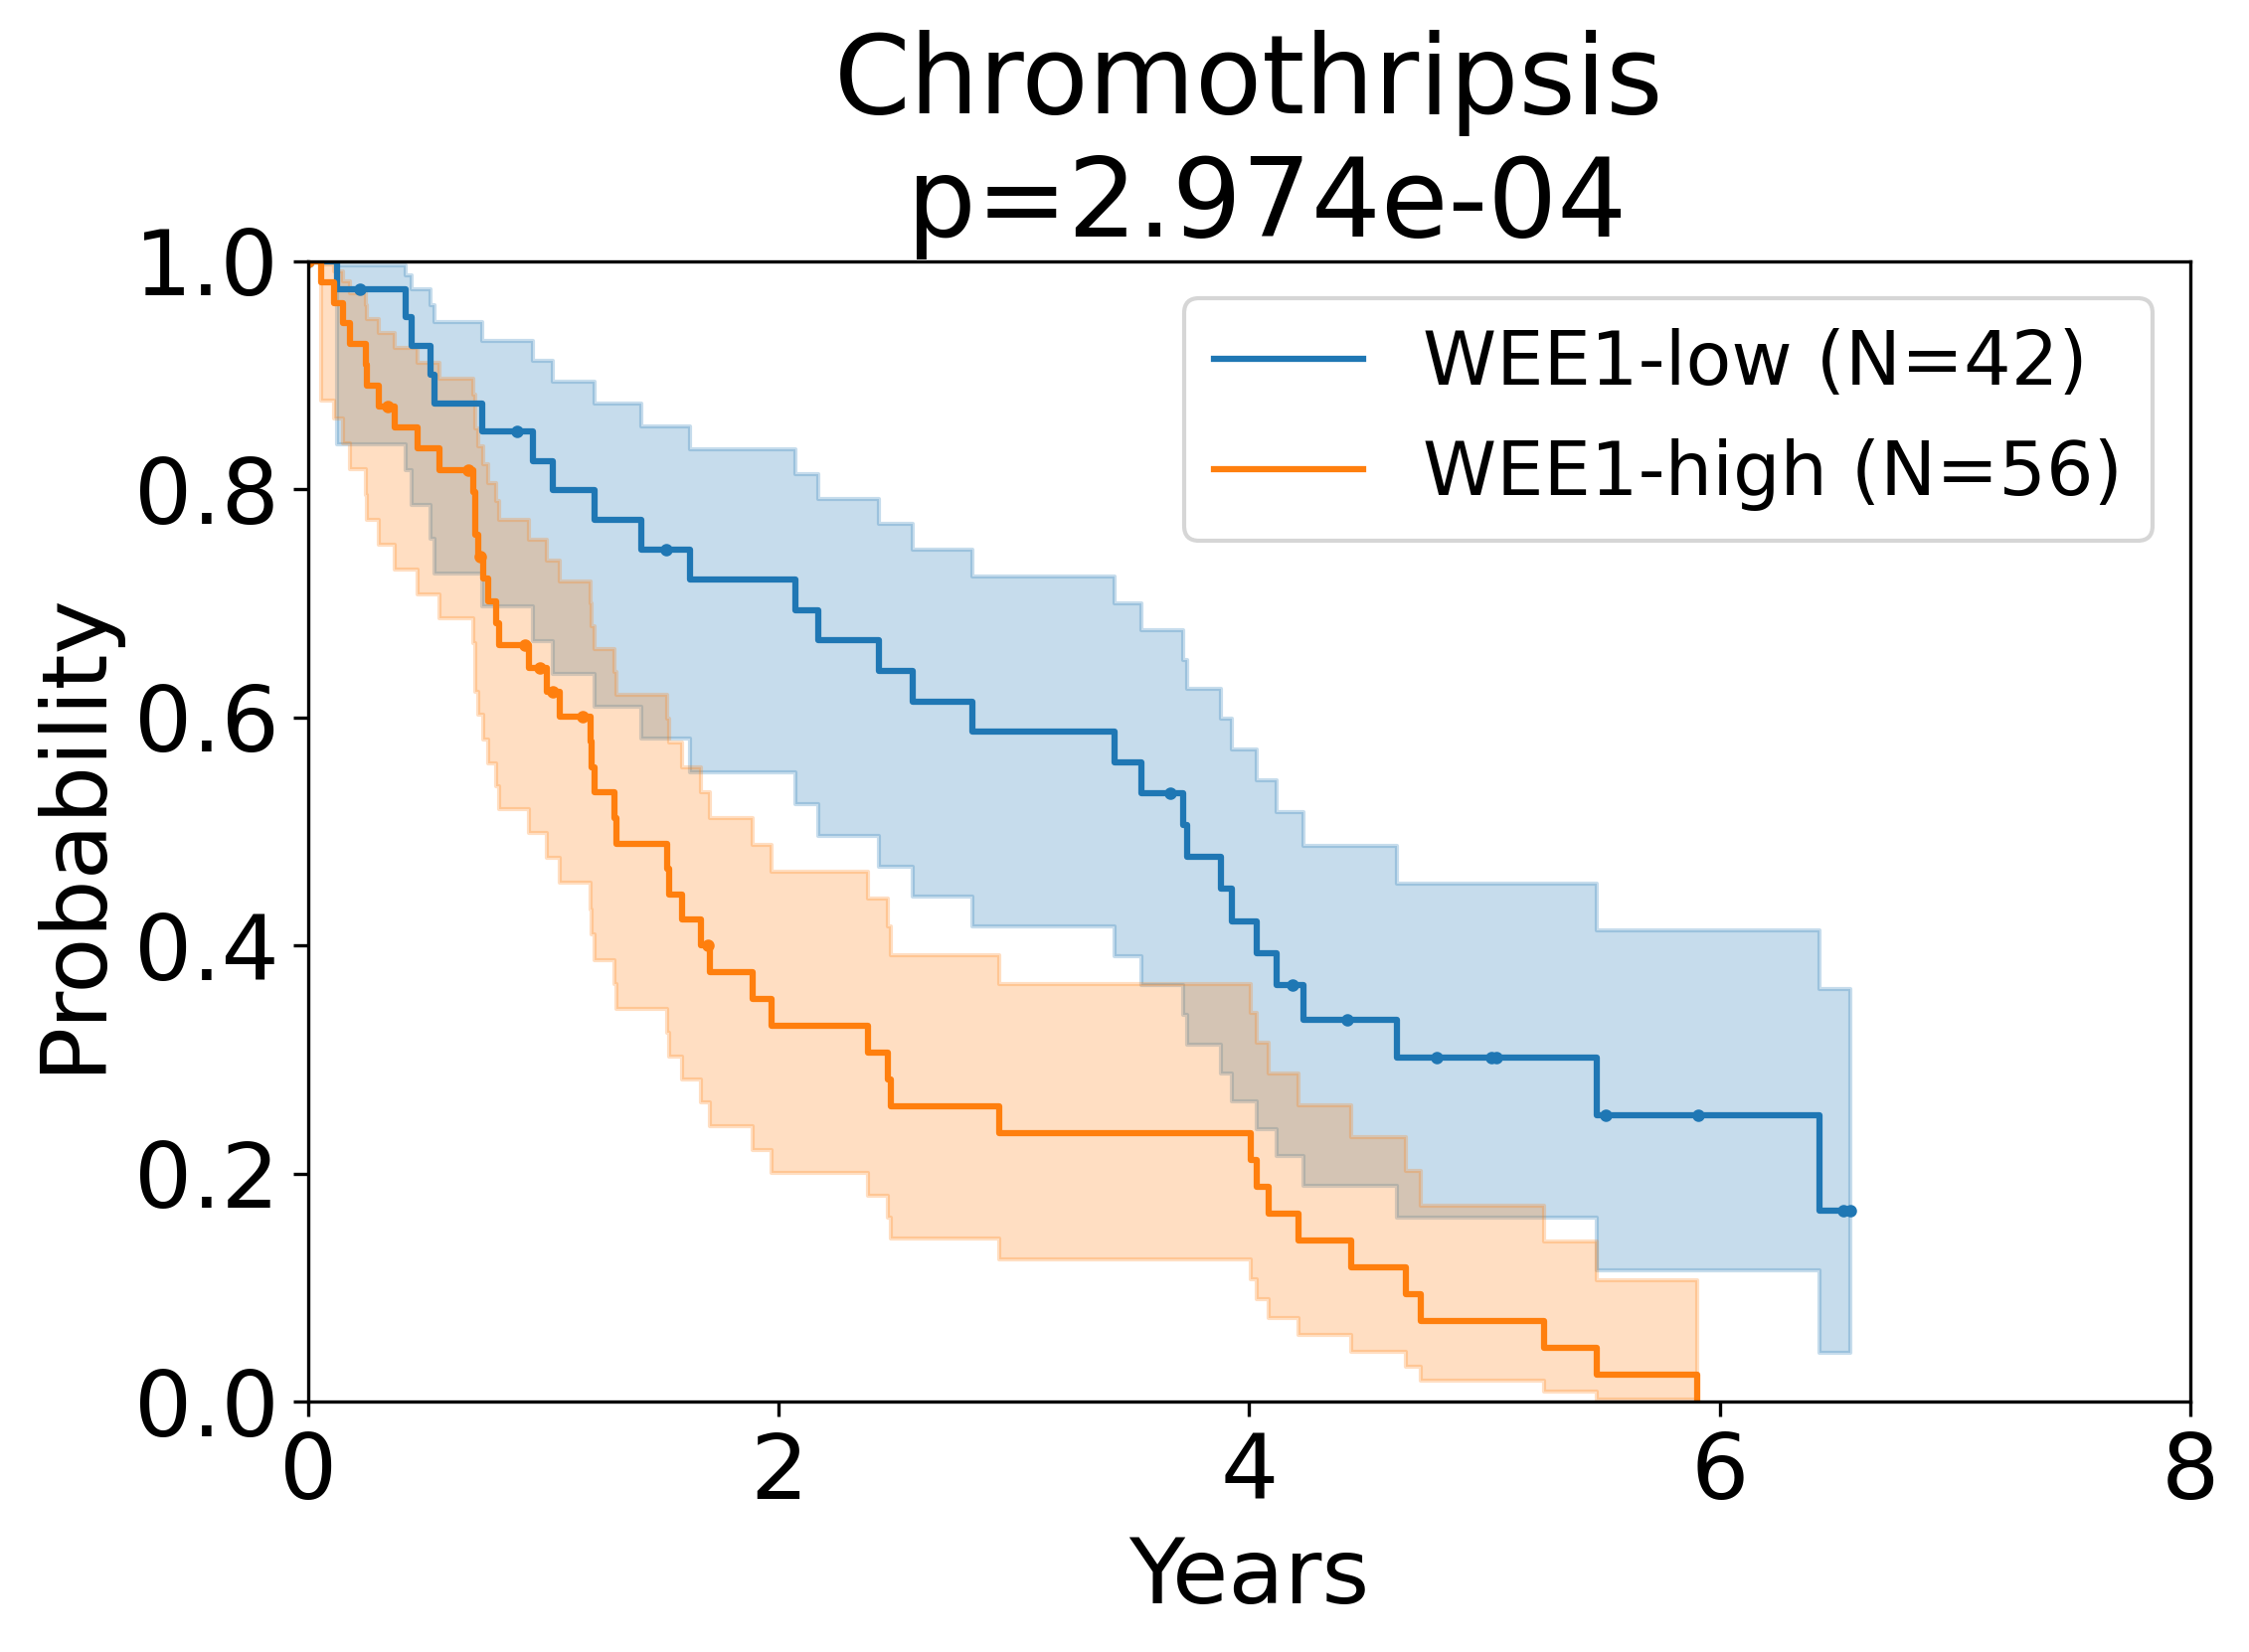

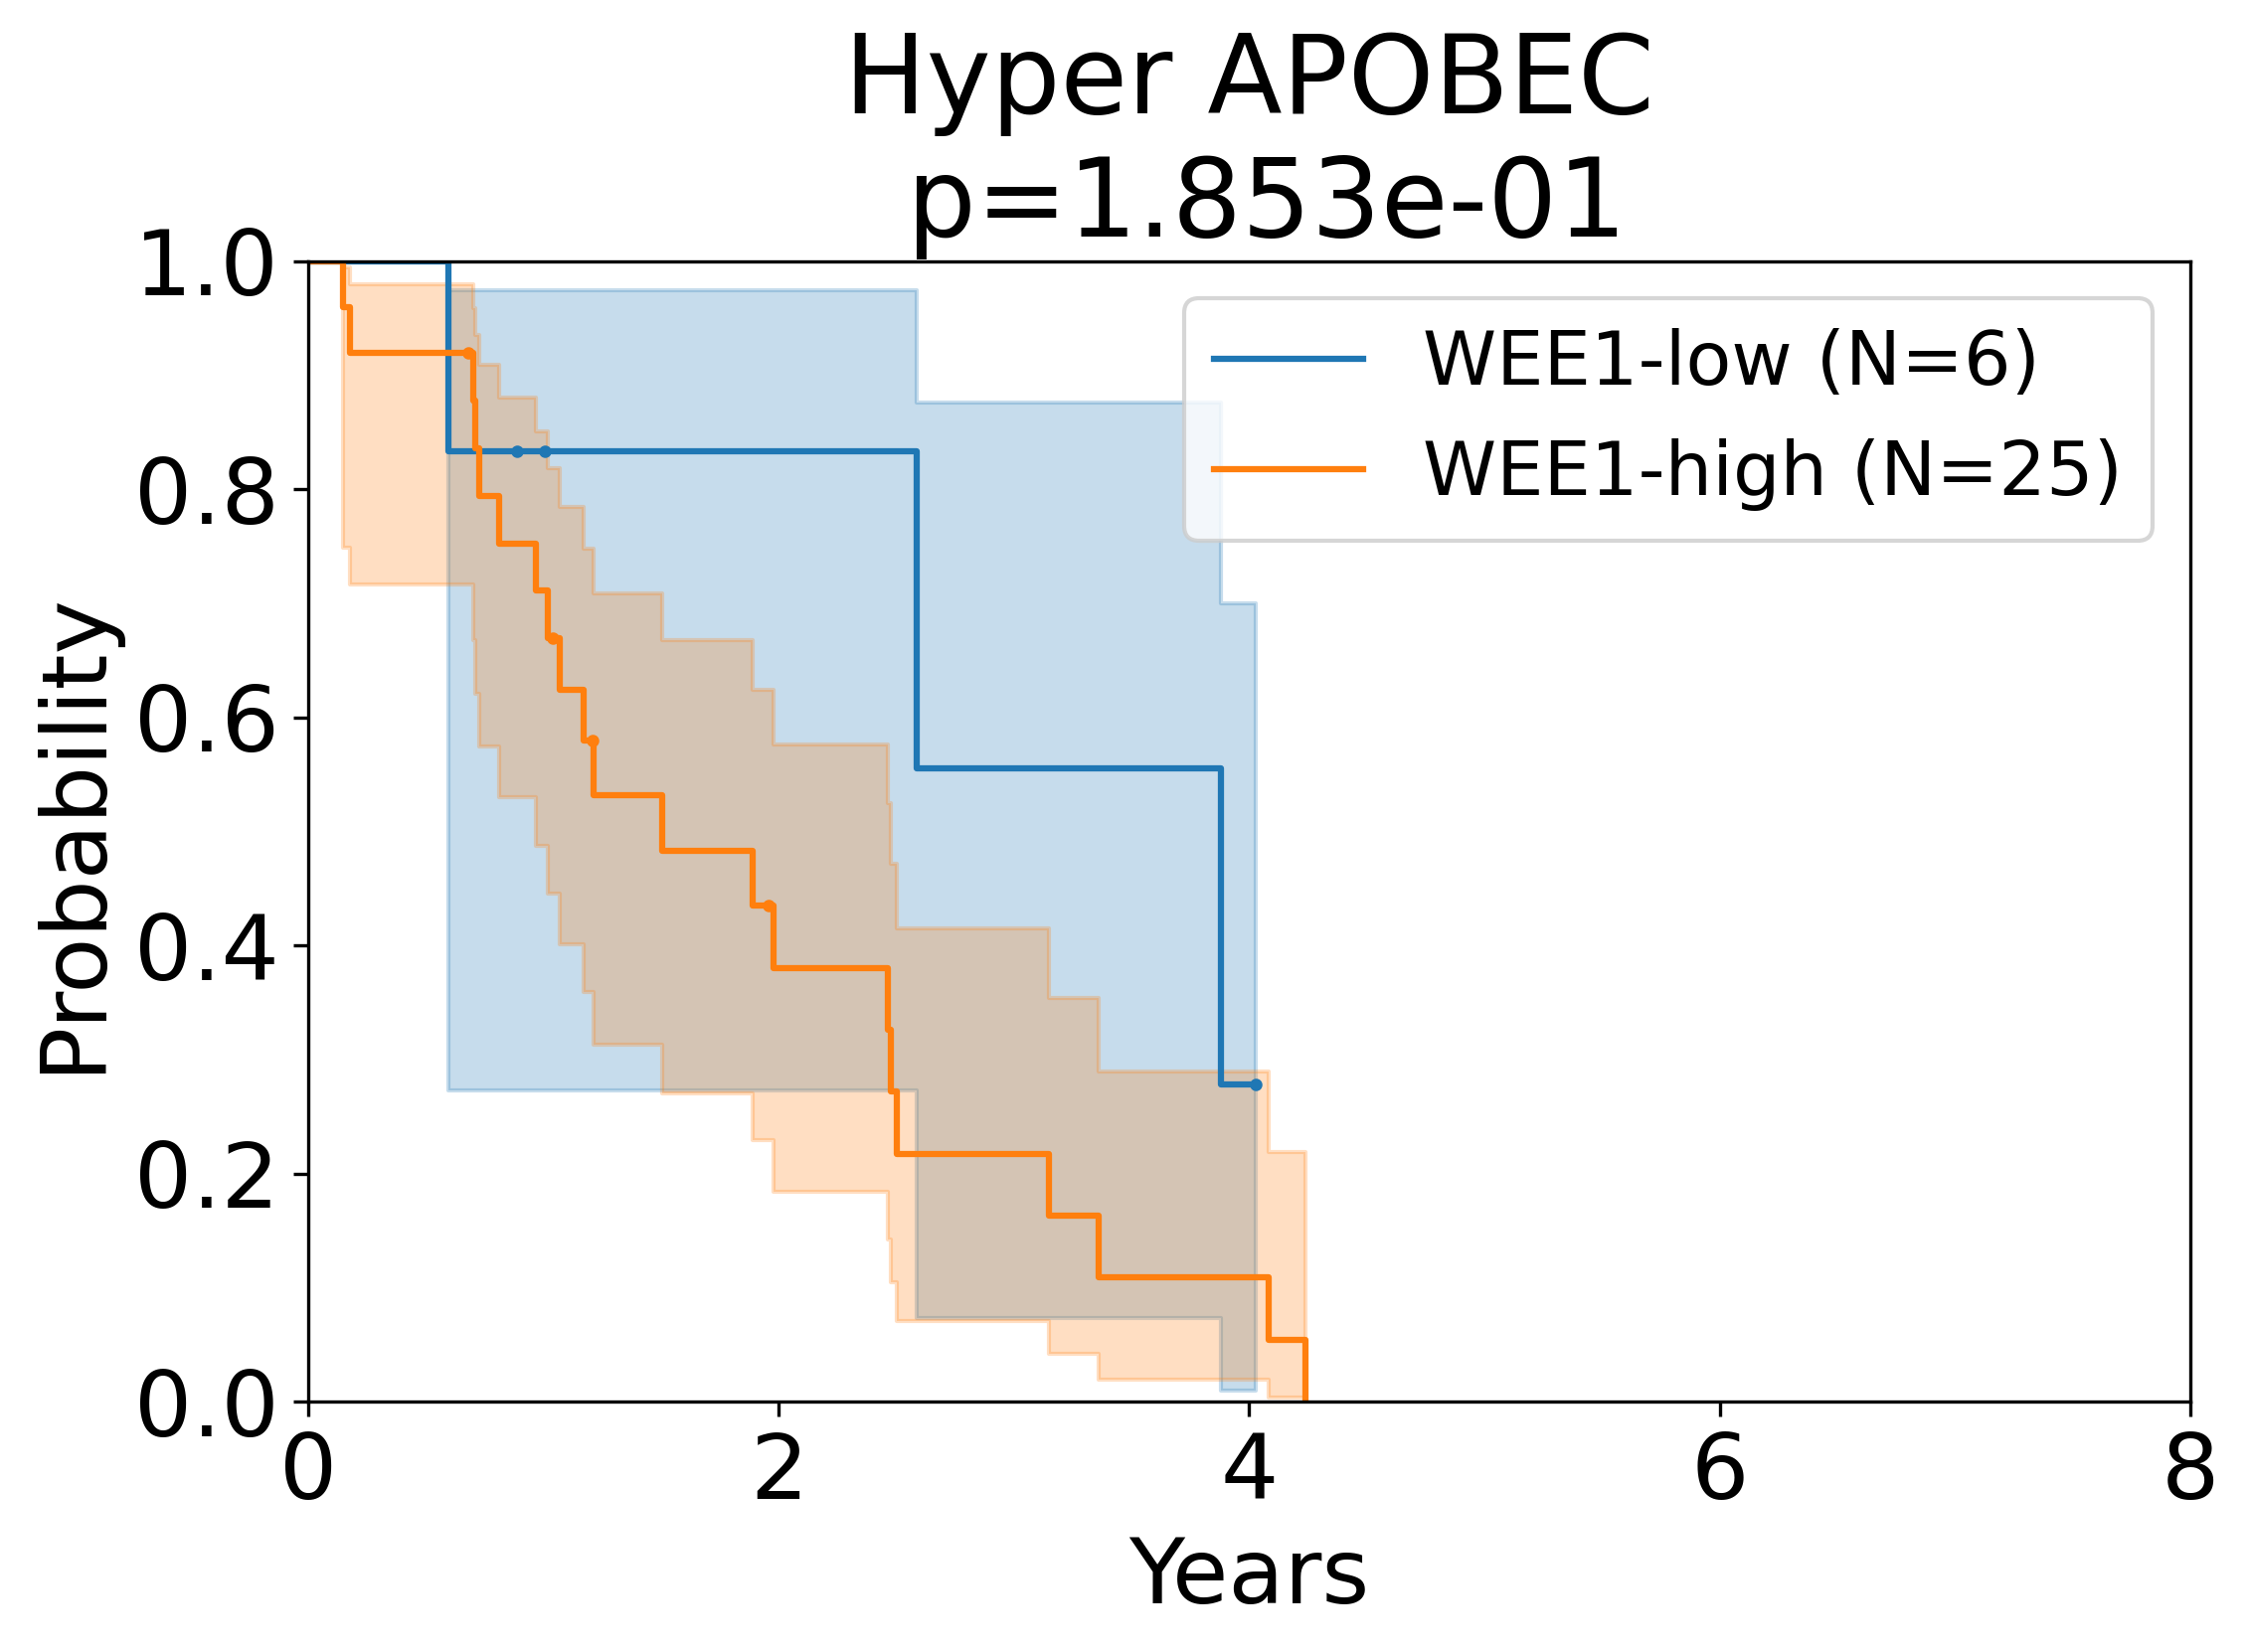

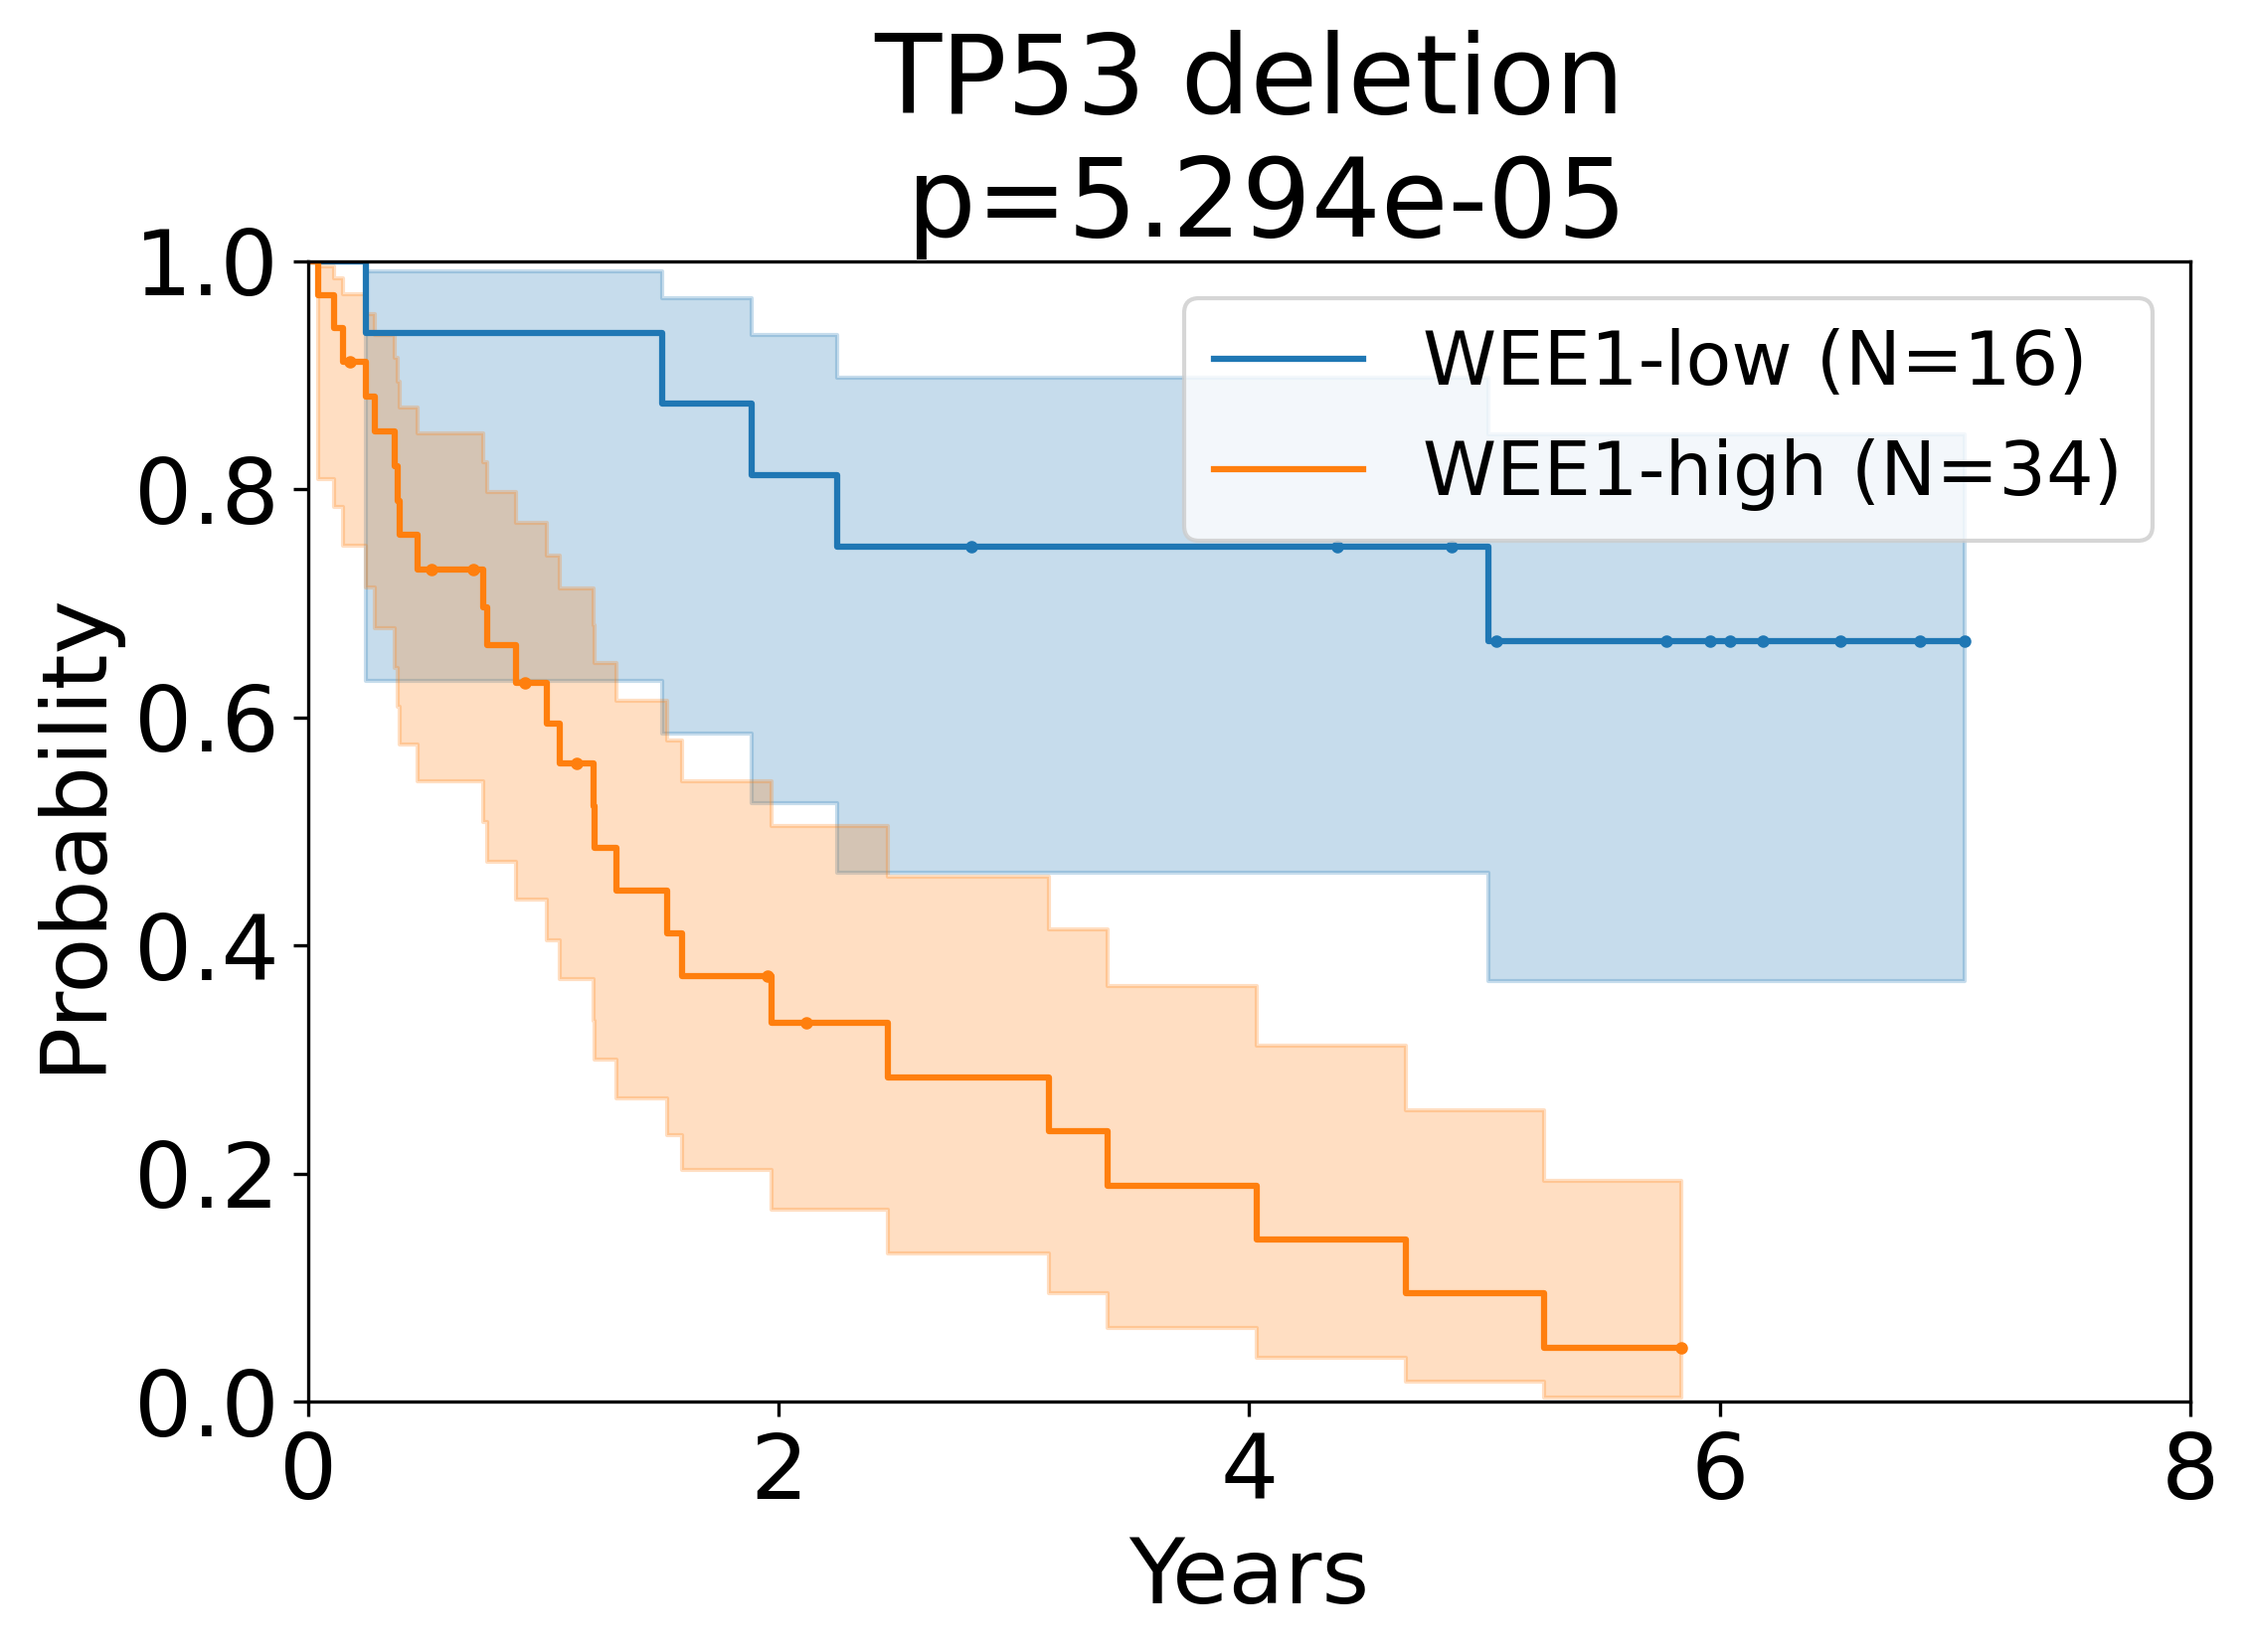

In [26]:
features_list = ['HRD', 't_MMSET', 't_CCND1', 'any_MAF',\
           't_MYC', 'chromothripsis_code', 'APOBEC_code',\
           'delTP53']

features_title_dict = {'HRD':'Hyperdiploidy', 't_MMSET':'t(4;14)',\
                       't_CCND1':'t(11;14)', 'any_MAF':'MAF translocation',\
                       't_MYC':'MYC translocation', 'chromothripsis_code':'Chromothripsis',\
                       'APOBEC_code':'Hyper APOBEC','delTP53':'TP53 deletion'}


wee1_text_labels = ['empty', 'low', 'high']
wee1_delta_list = [] 

for feature_name in features_list: 
    print('-------------') 
    print(feature_name) 

    feature_df = wee1_hi_lo_df[wee1_hi_lo_df[feature_name]>0]
    
    plt.figure(dpi=300, figsize=(8, 6))
    # plt.figure()
    ax = plt.subplot(111)

    e_duration = feature_df['event_duration'].values
    w_labels = feature_df['wee1_labels'].values
    censor_list = feature_df['censorlist'].values
    
    output = multivariate_logrank_test(e_duration, w_labels, censor_list)
    
    kmf = KaplanMeierFitter()
    kmf_median_list = np.zeros(4)
    for ncluster in [1, 2]: 
        kmf.fit(e_duration[w_labels==ncluster],\
                censor_list[w_labels==ncluster],\
                label="WEE1-"+ wee1_text_labels[ncluster]+ " (N="+ str(sum(w_labels==ncluster)) +")")
        kmf.plot_survival_function(ax=ax,  show_censors=True,\
                                   censor_styles={'ms': 2, 'marker': 'o'}, ci_show=True)
        print(ncluster, np.round(kmf.median_survival_time_, 5), ' years')
        kmf_median_list[ncluster] = kmf.median_survival_time_
    plt.title(features_title_dict[feature_name] + "\n p=" + "{:.3e}".format(output.p_value))
    plt.xlabel('Years')
    plt.ylabel('Probability')
    plt.xlim(0, 8)
    plt.ylim(0, 1) 
    
    plt.rcParams.update({'font.size': 22})
    plt.legend(loc='upper right', fontsize="18")
    plt.tight_layout()
    
    wee1_delta_list.append(kmf_median_list[1] - kmf_median_list[2])
    print()
    plt.savefig(features_title_dict[feature_name] + '.png')
     

In [27]:
wee1_delta_list

[1.838356164383562,
 1.1150684931506847,
 inf,
 inf,
 2.1205479452054794,
 2.427397260273973,
 2.3780821917808224,
 inf]

-------------
HRD
1 4.65479  years
2 1.96986  years
-------------
t_MMSET
1 4.63014  years
2 2.19452  years
-------------
t_CCND1
1 3.92603  years
2 1.96986  years
-------------
any_MAF
1 4.03288  years
2 2.11233  years
-------------
t_MYC
1 4.63014  years
2 2.19452  years
-------------
chromothripsis_code
1 4.93151  years
2 2.50411  years
-------------
APOBEC_code
1 4.14521  years
2 2.20274  years
-------------
delTP53
1 3.88767  years
2 2.27945  years


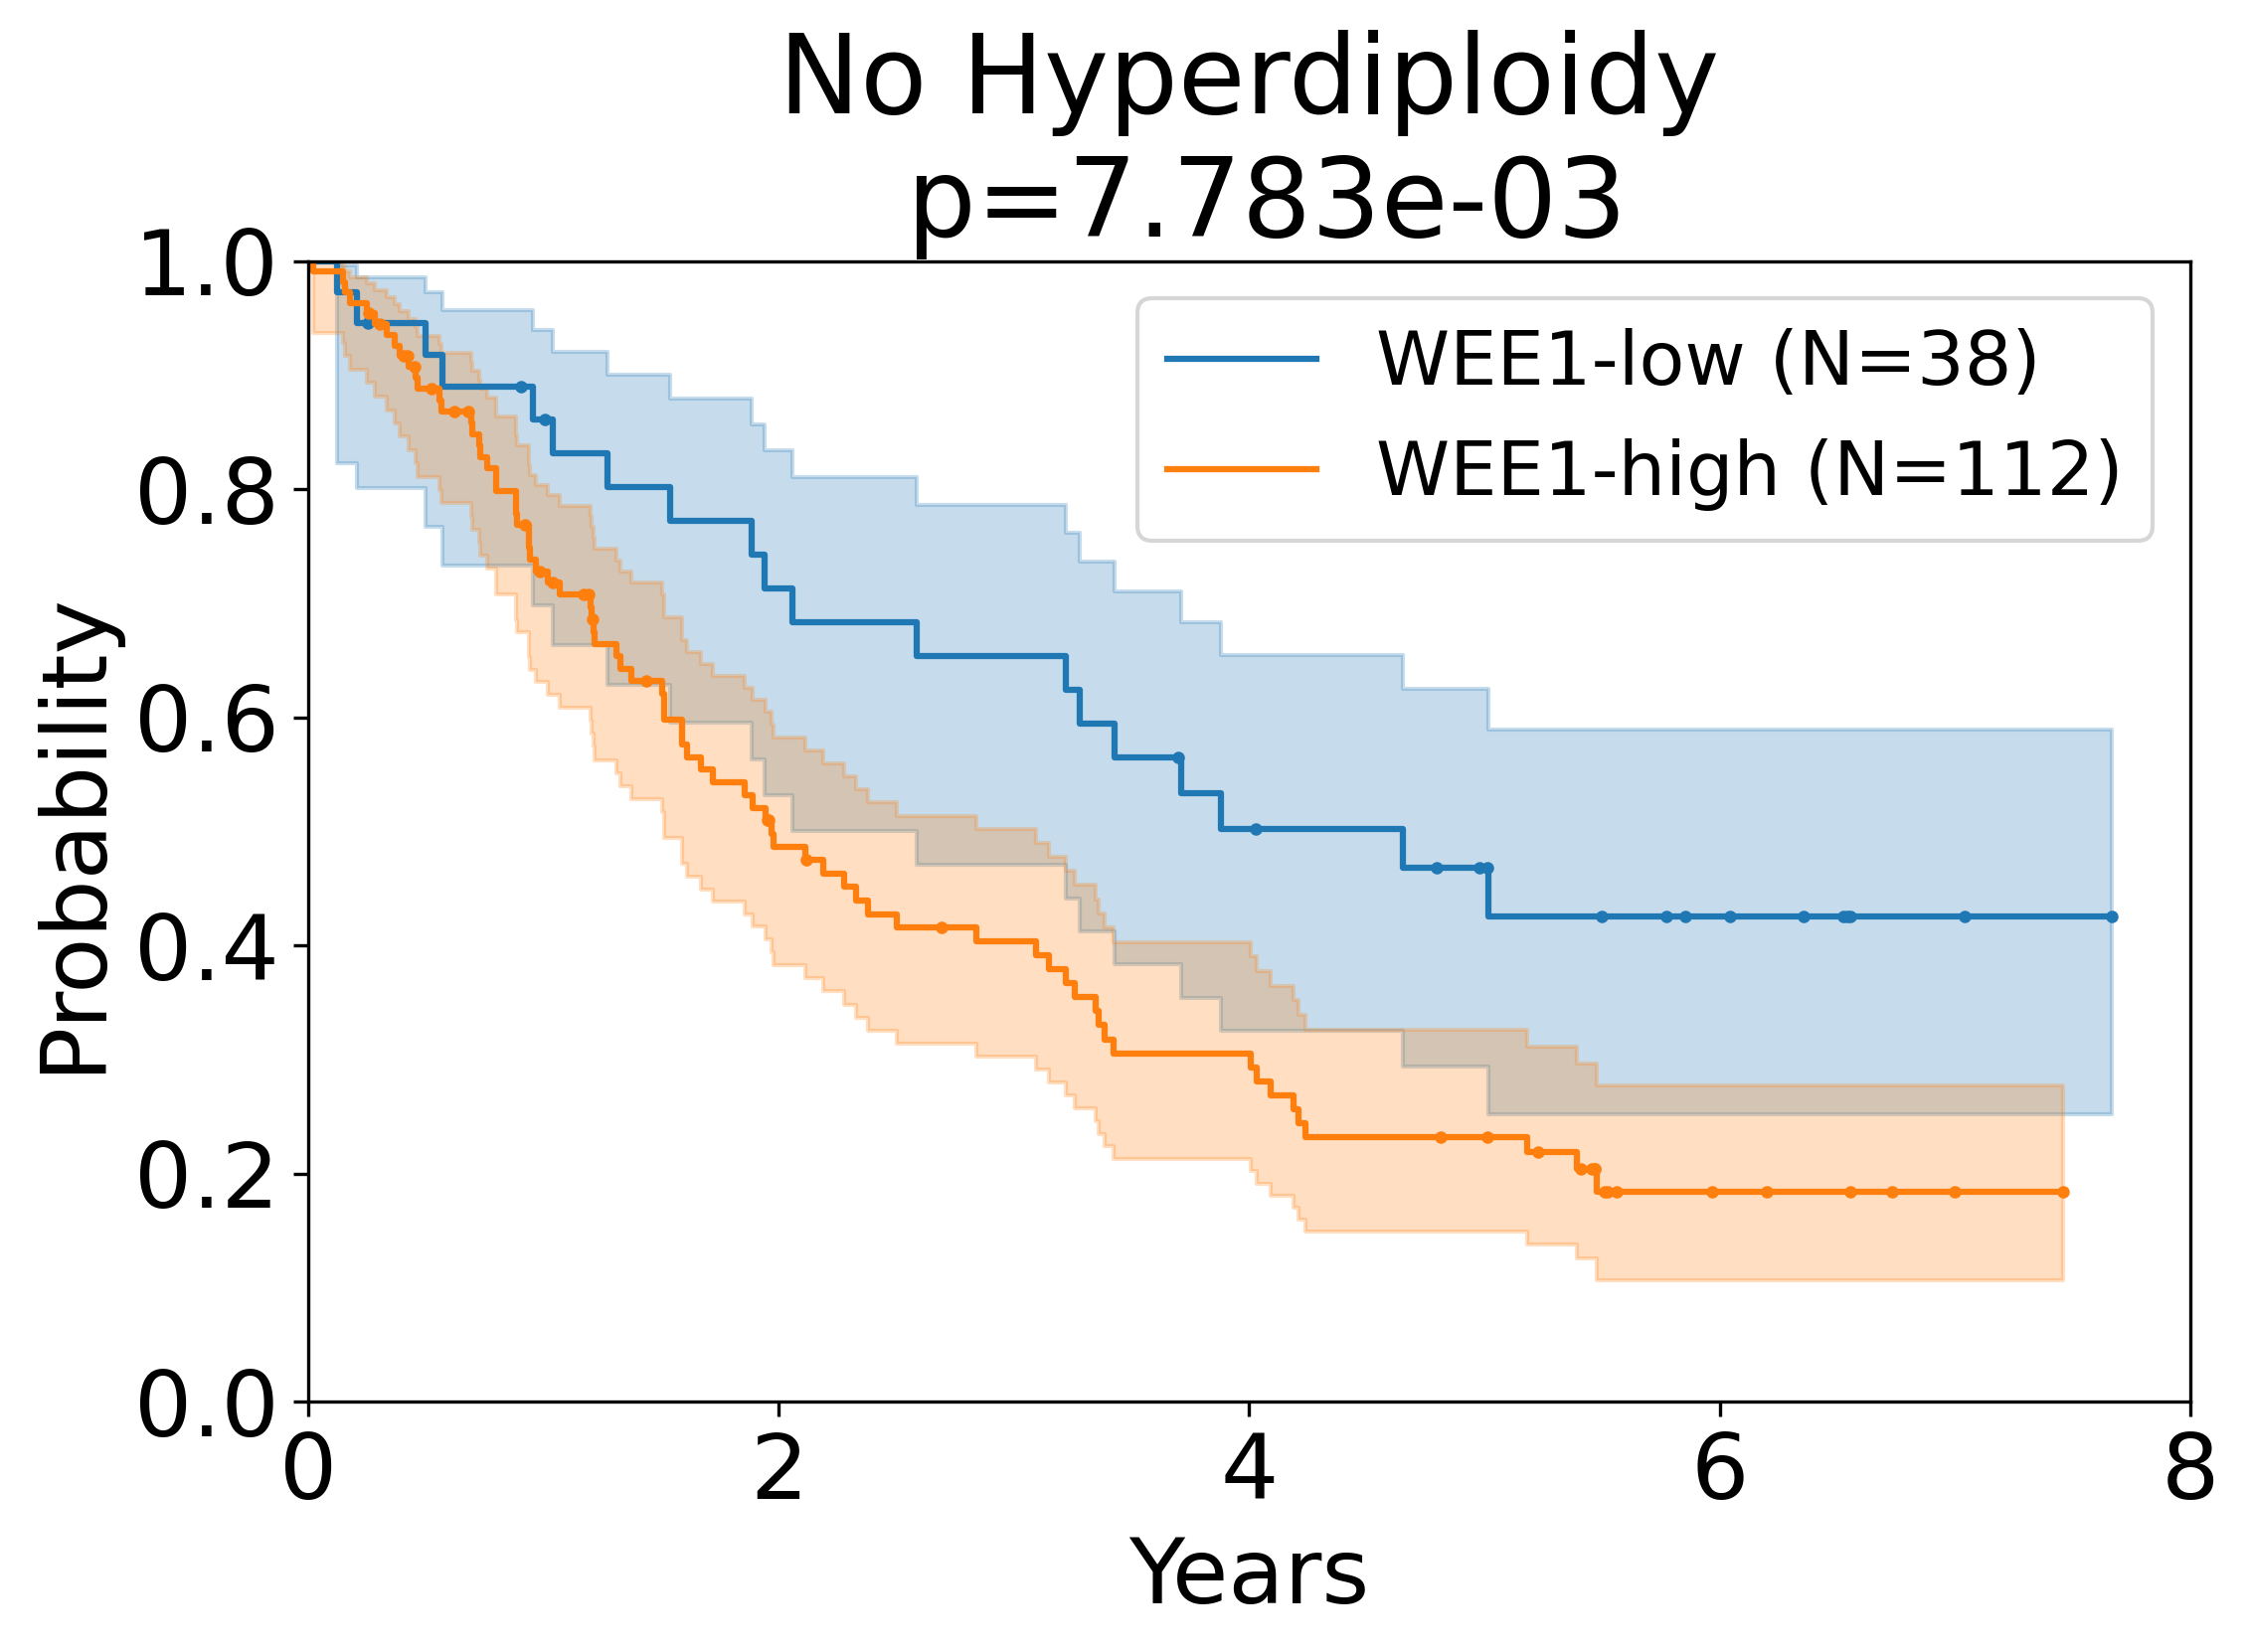

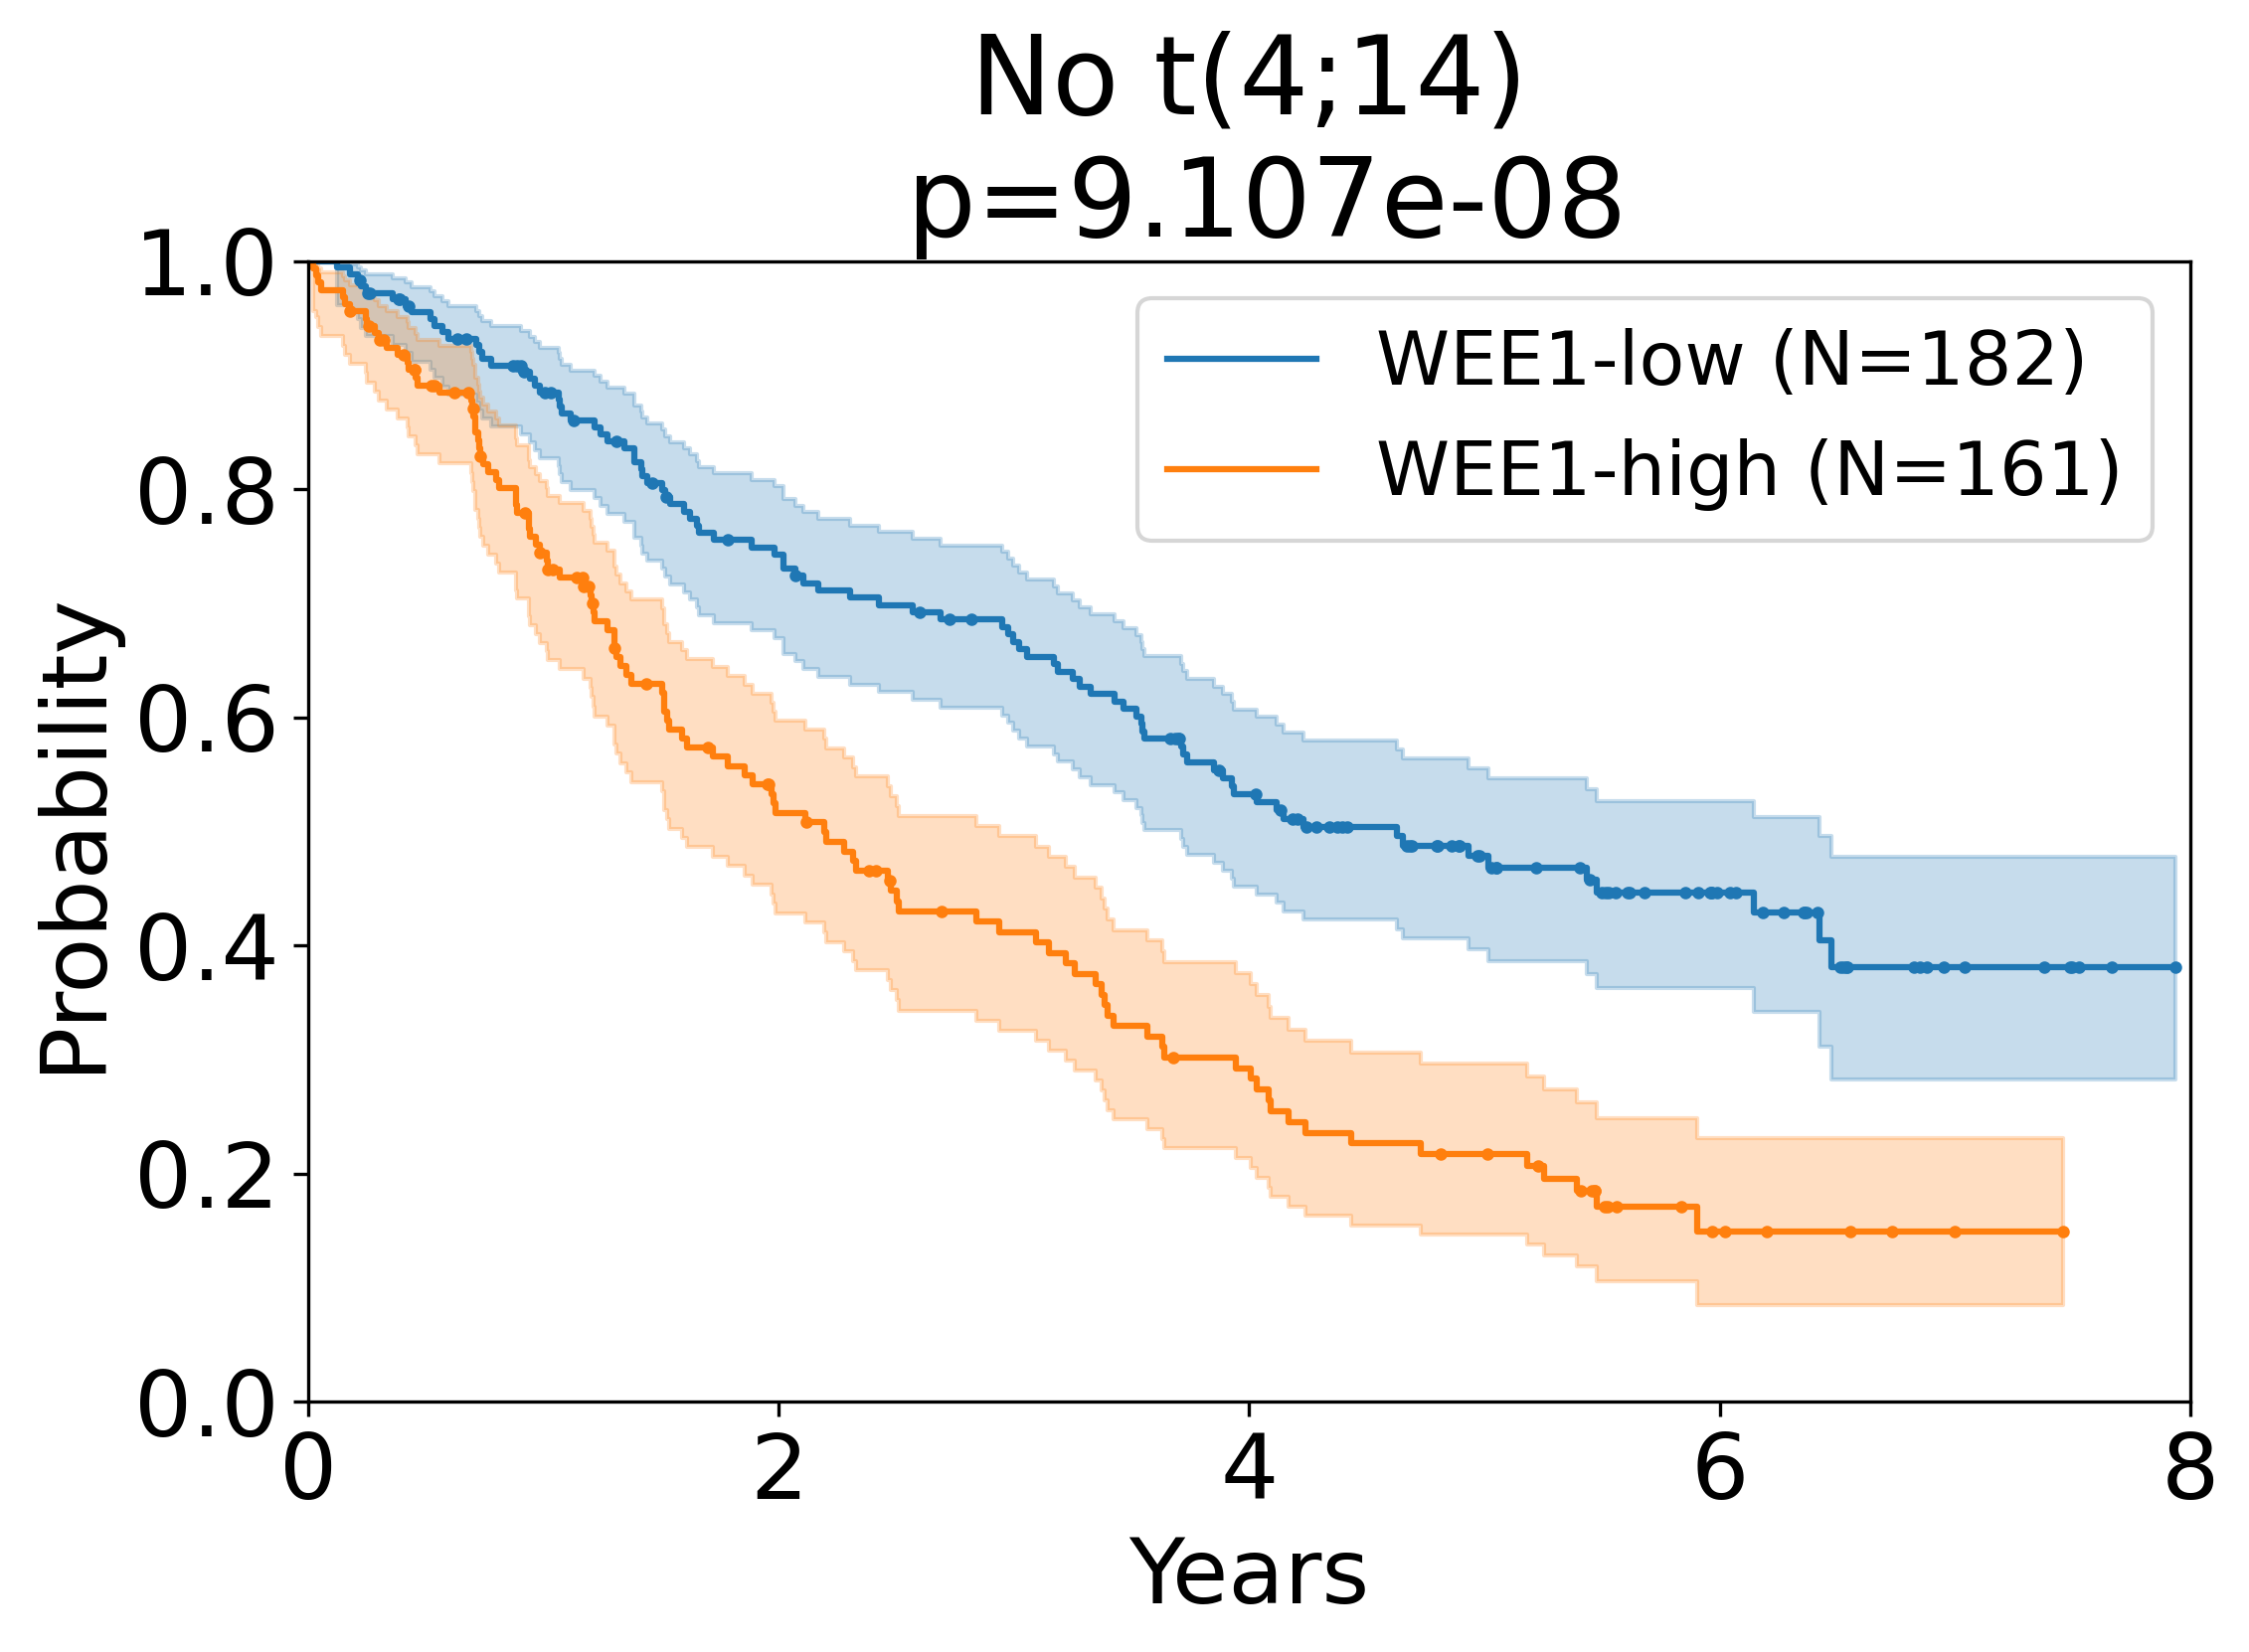

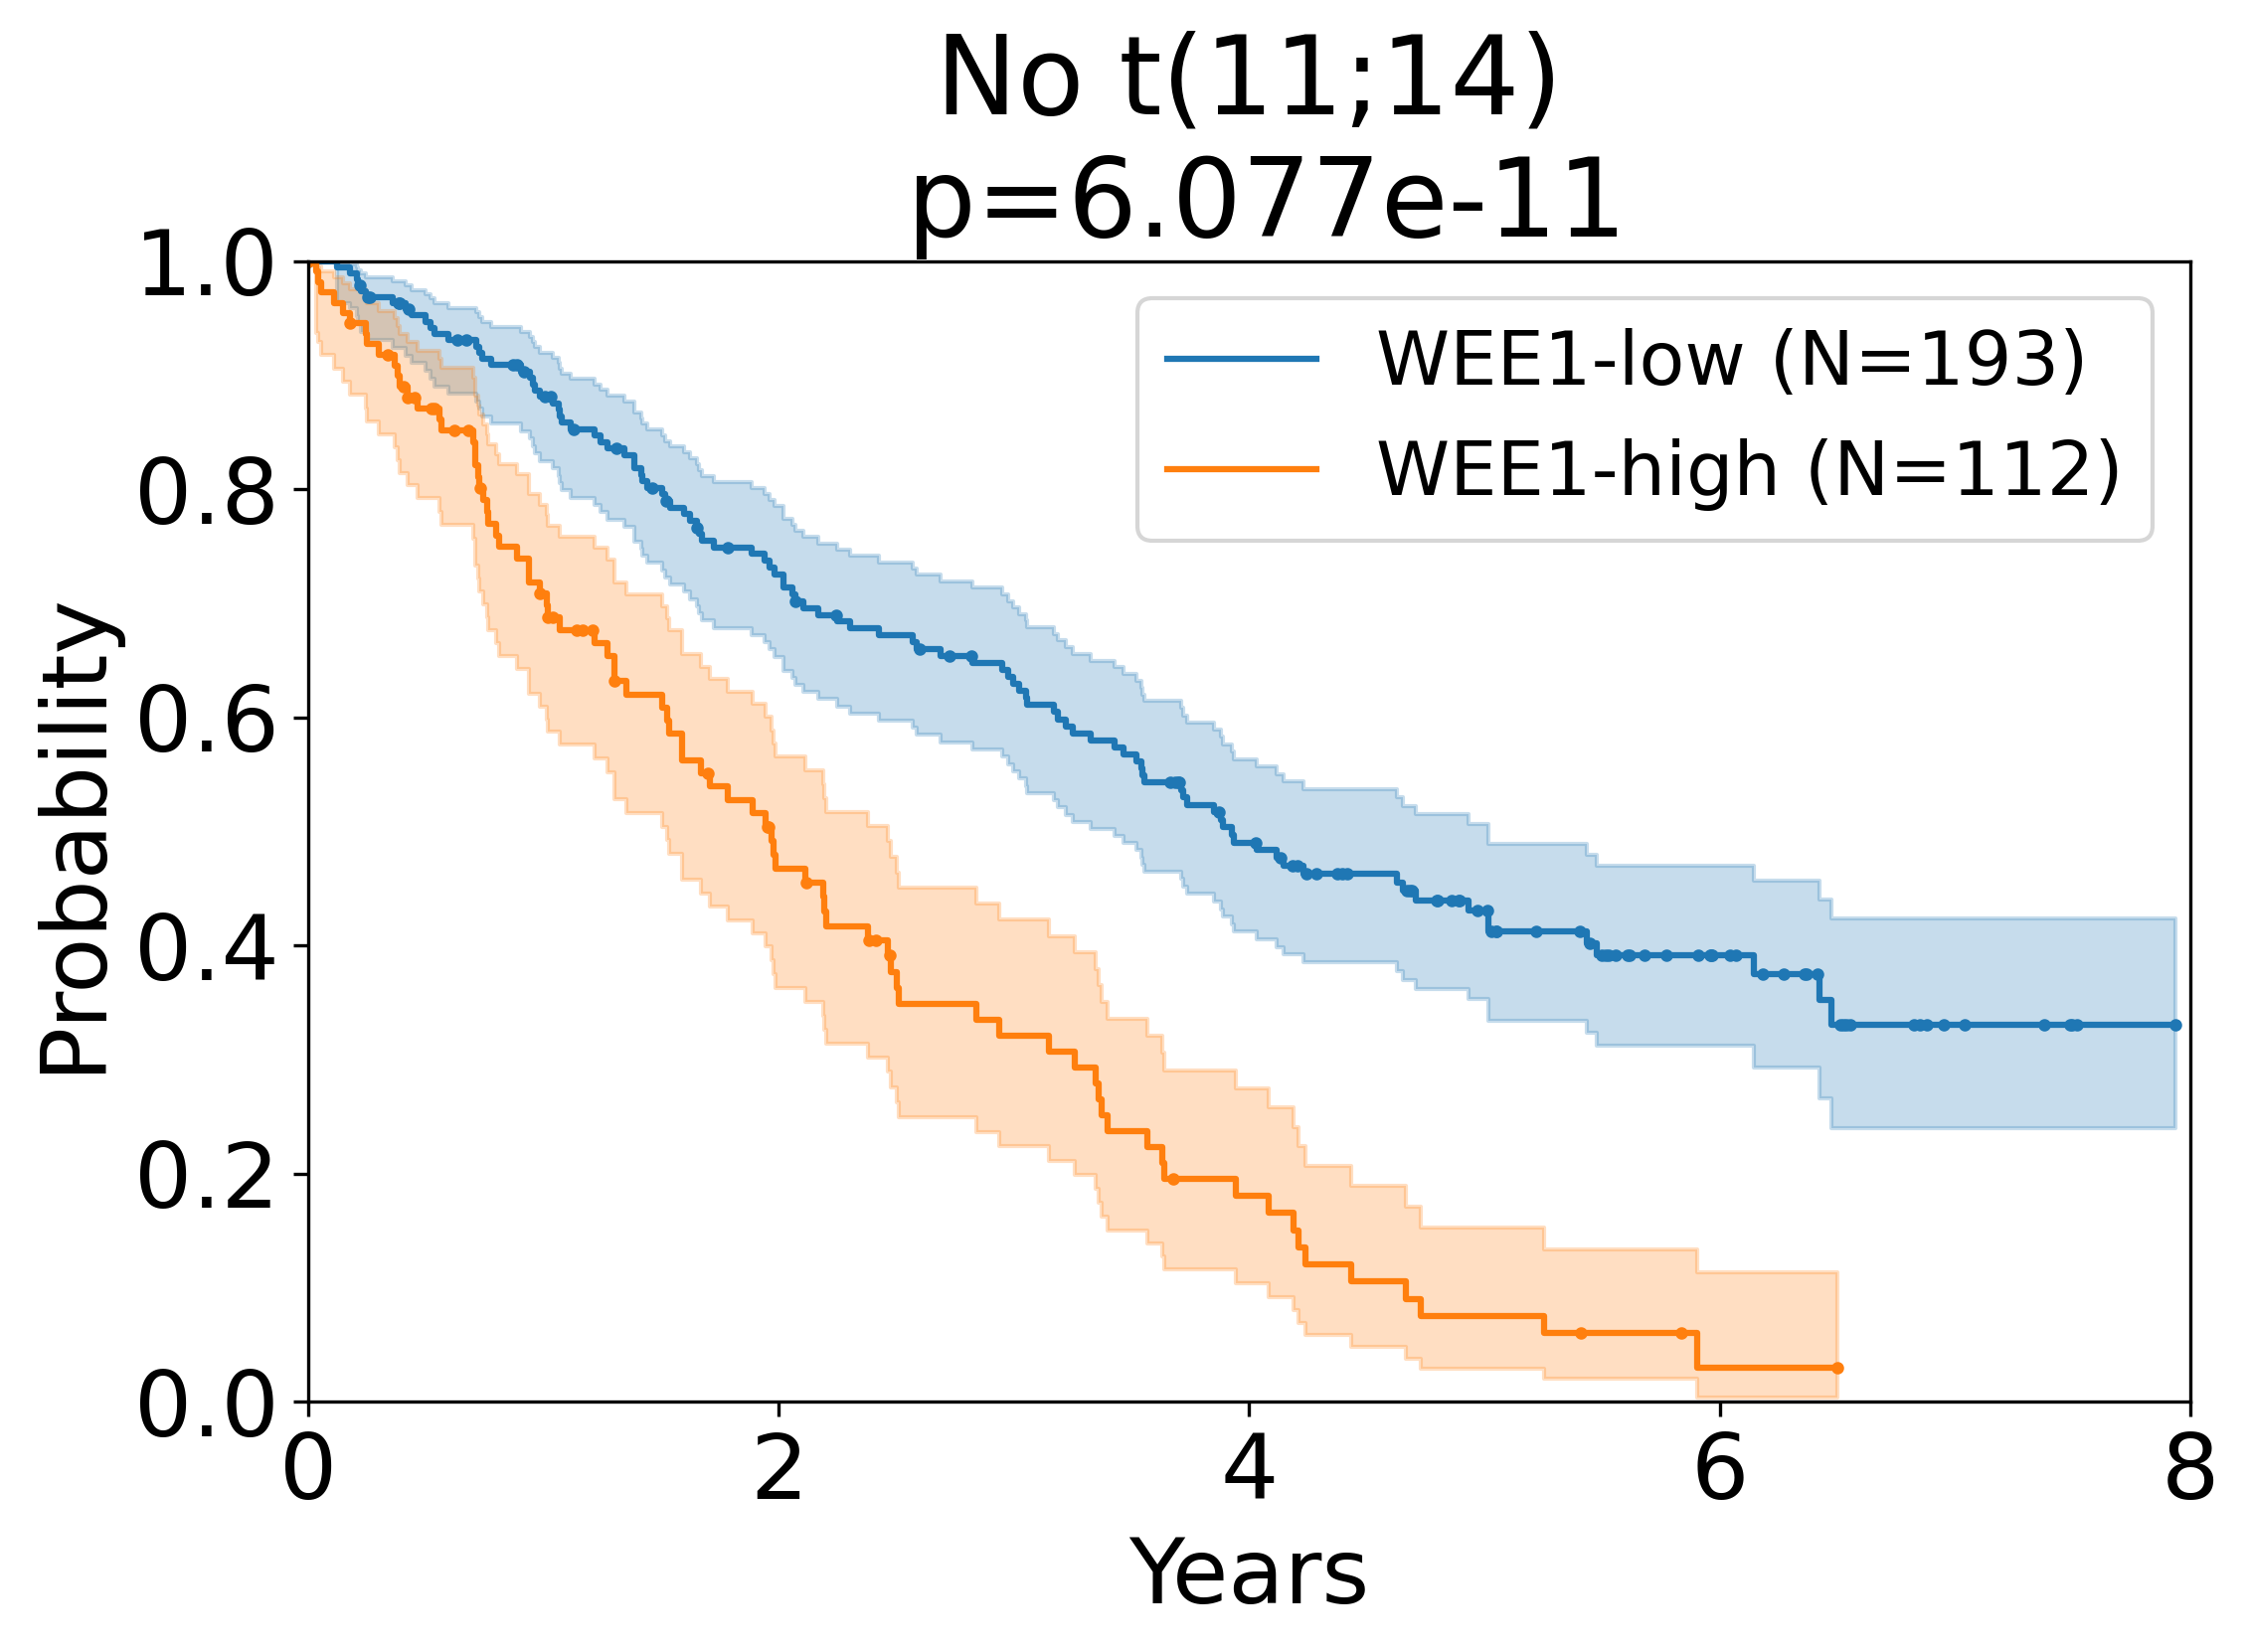

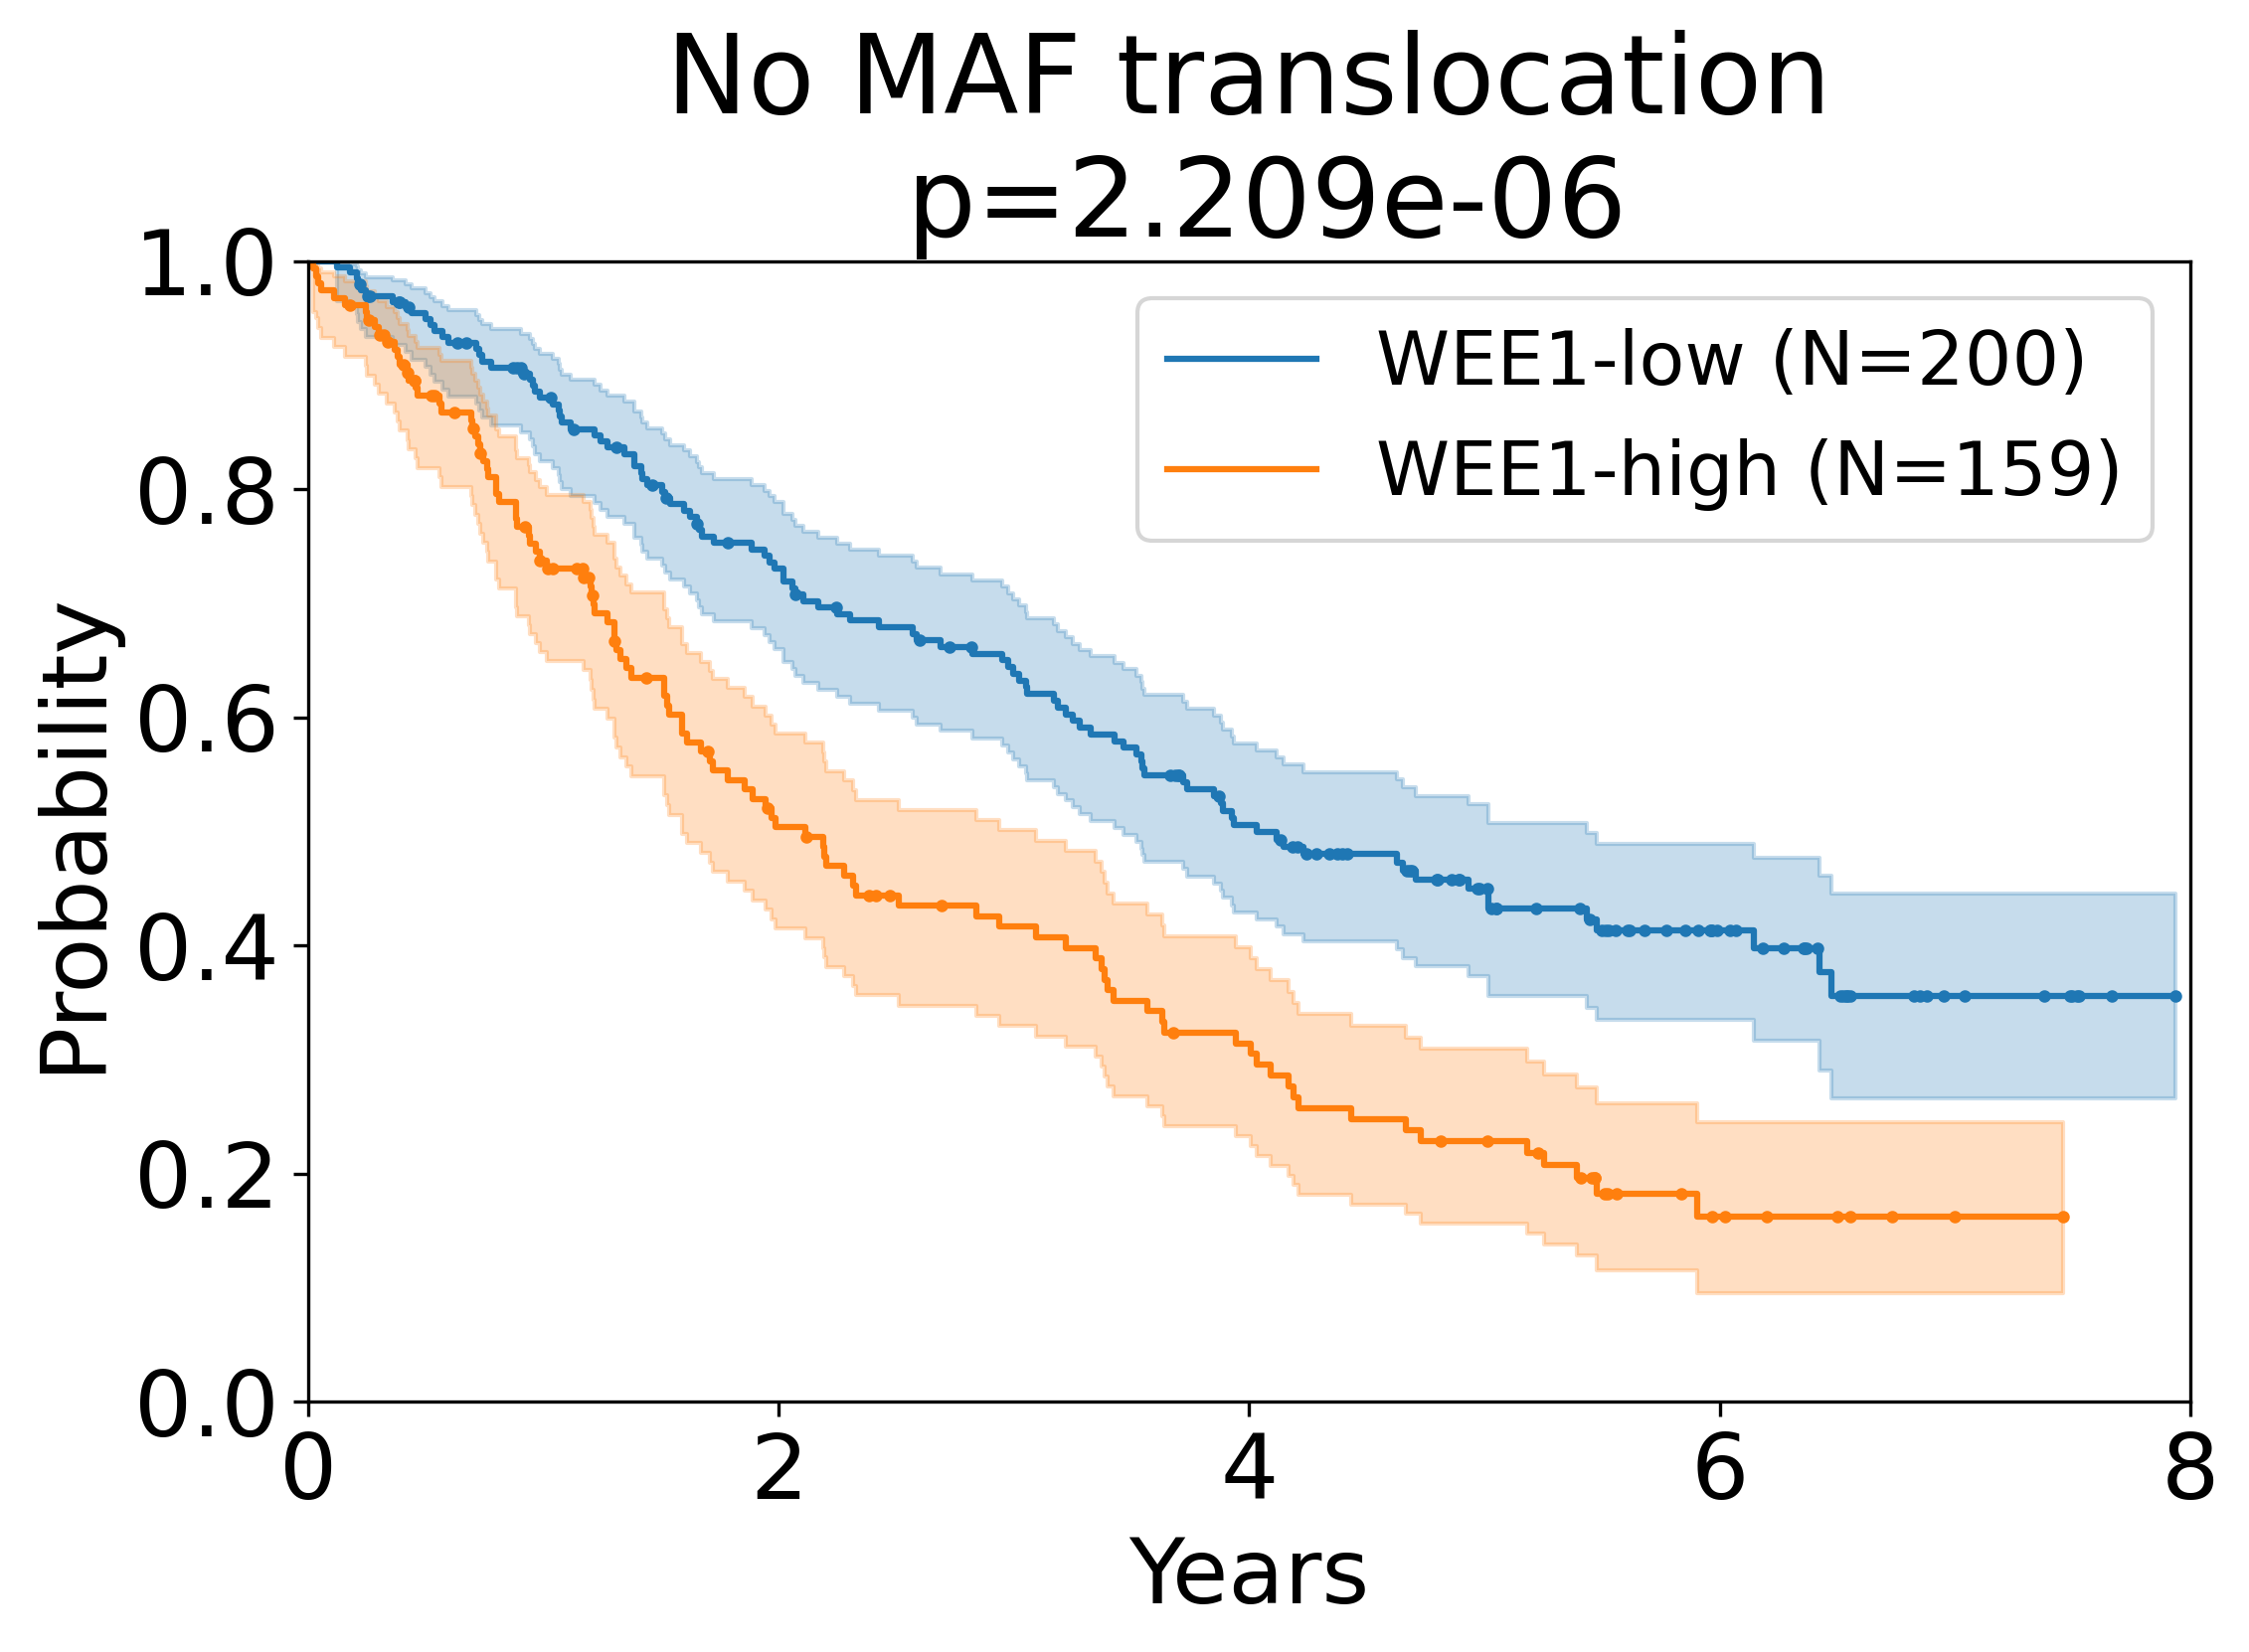

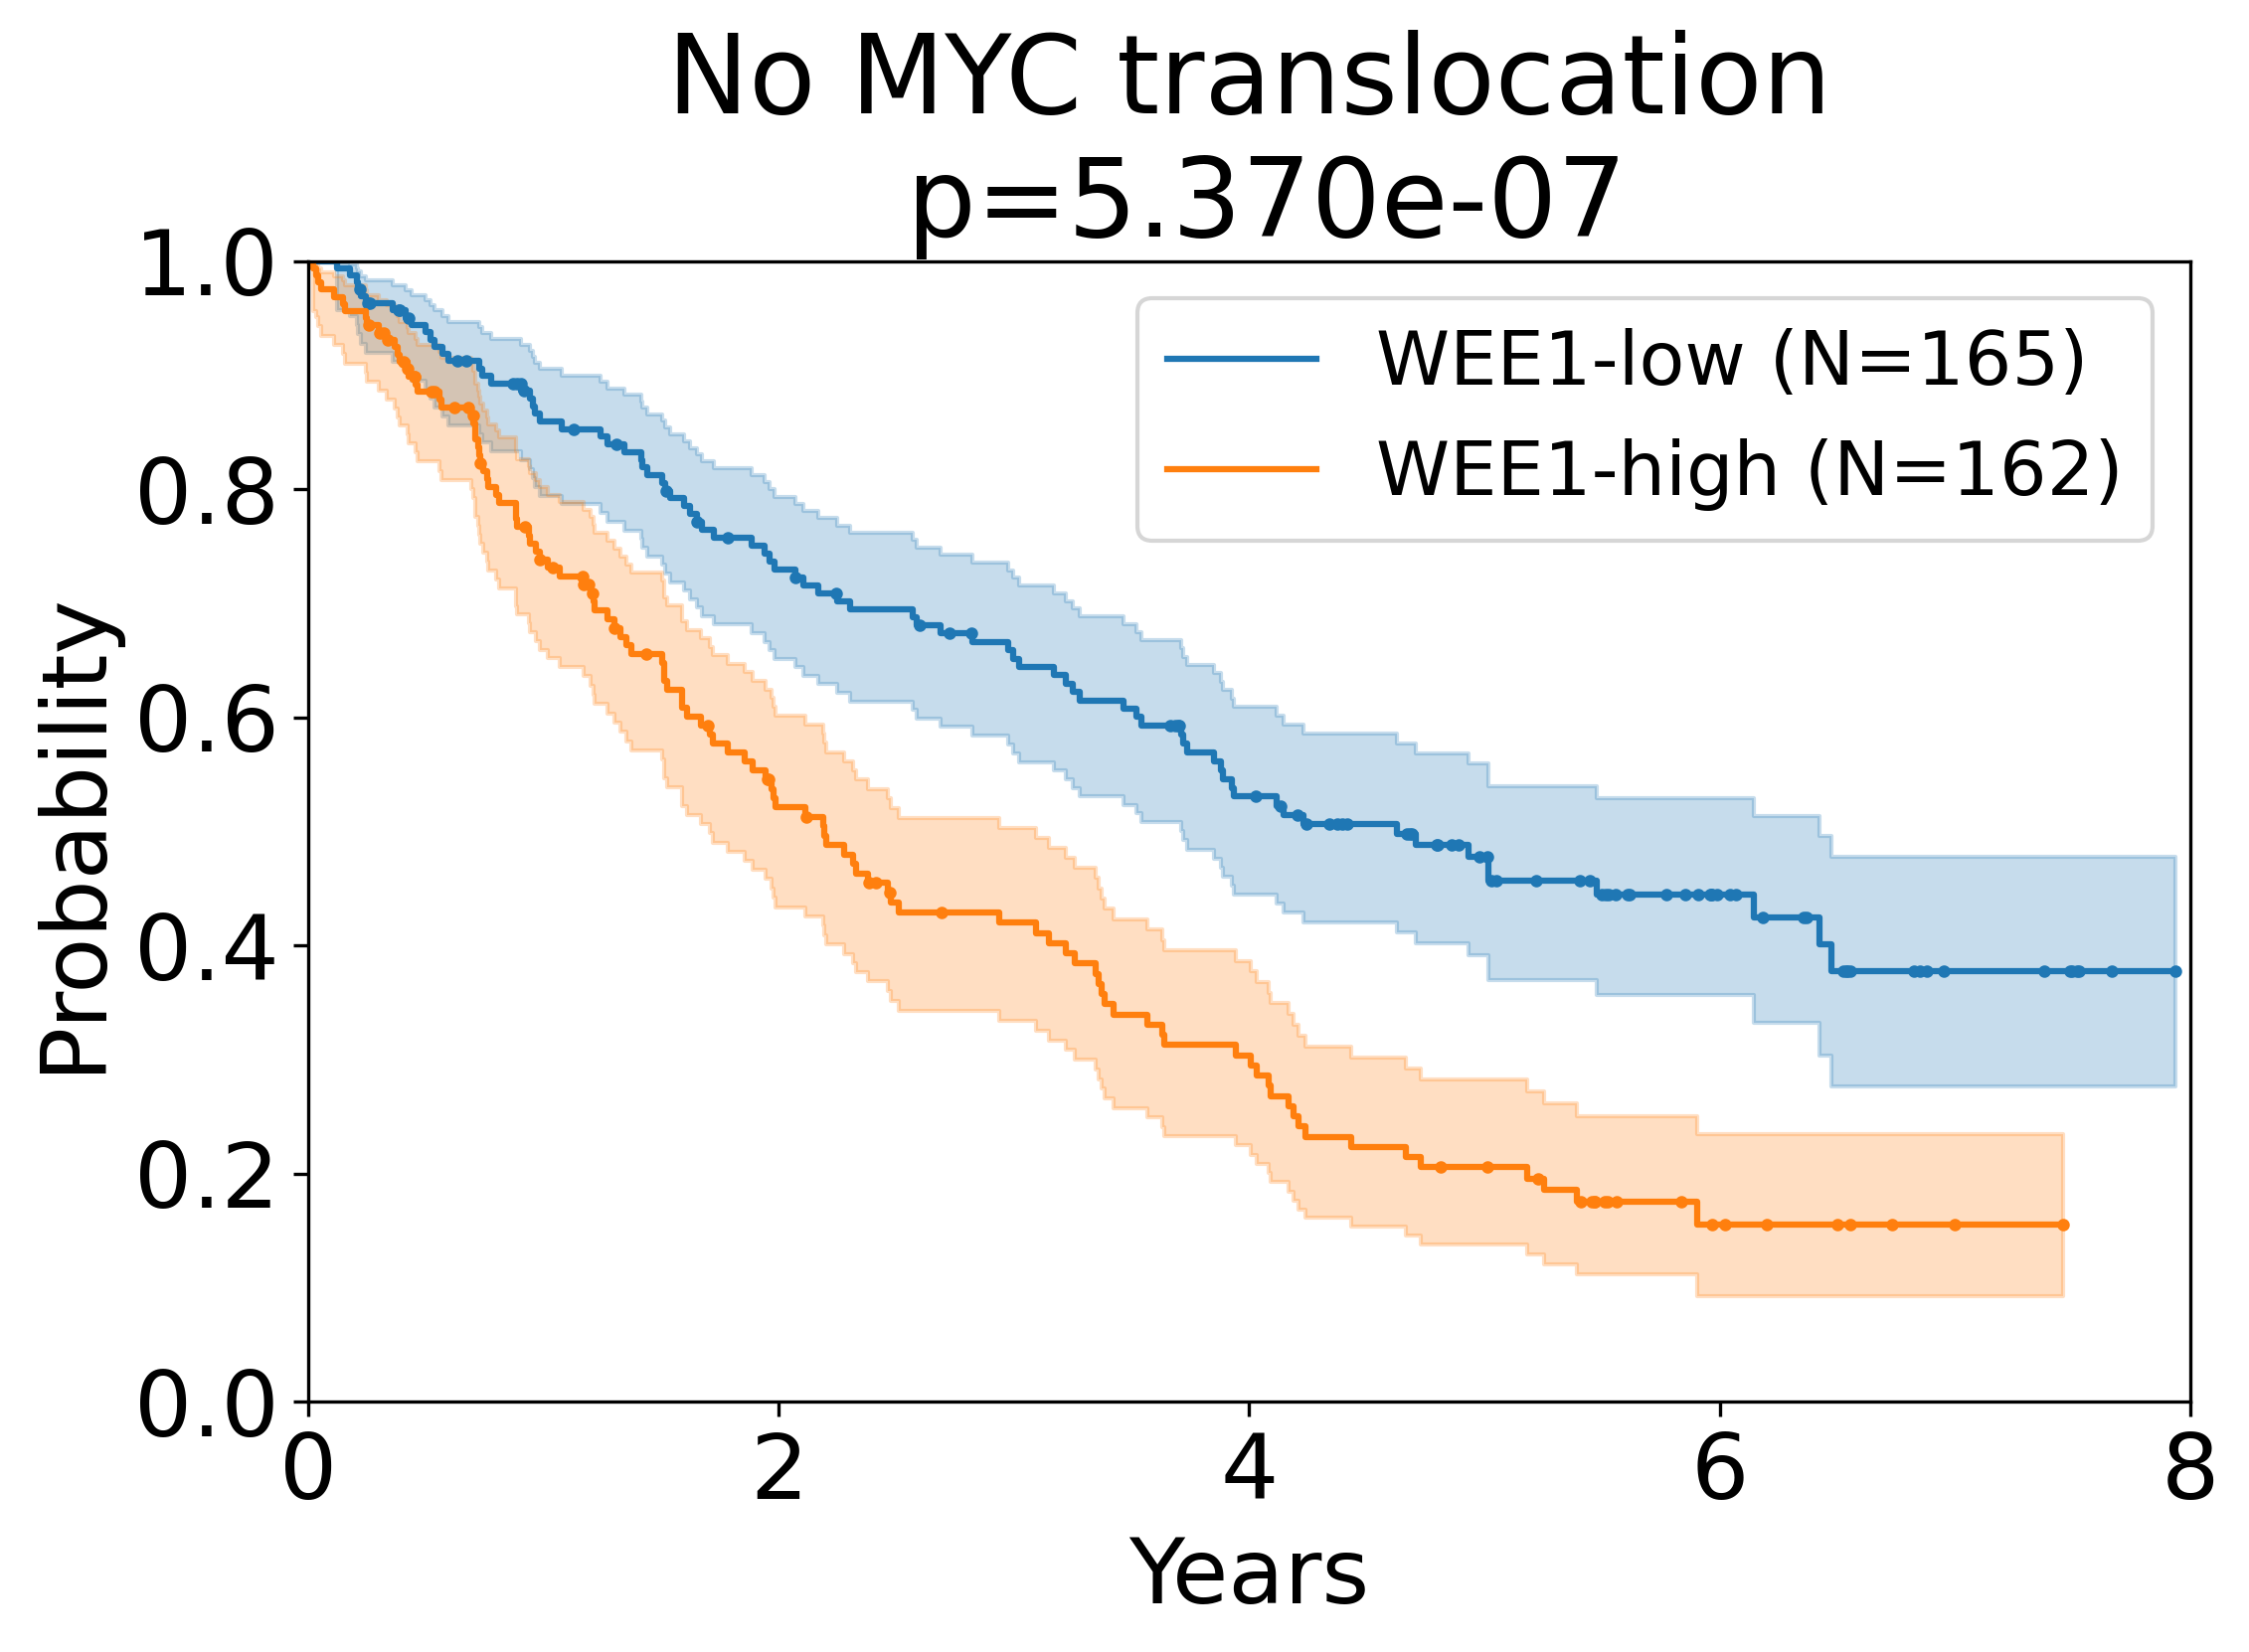

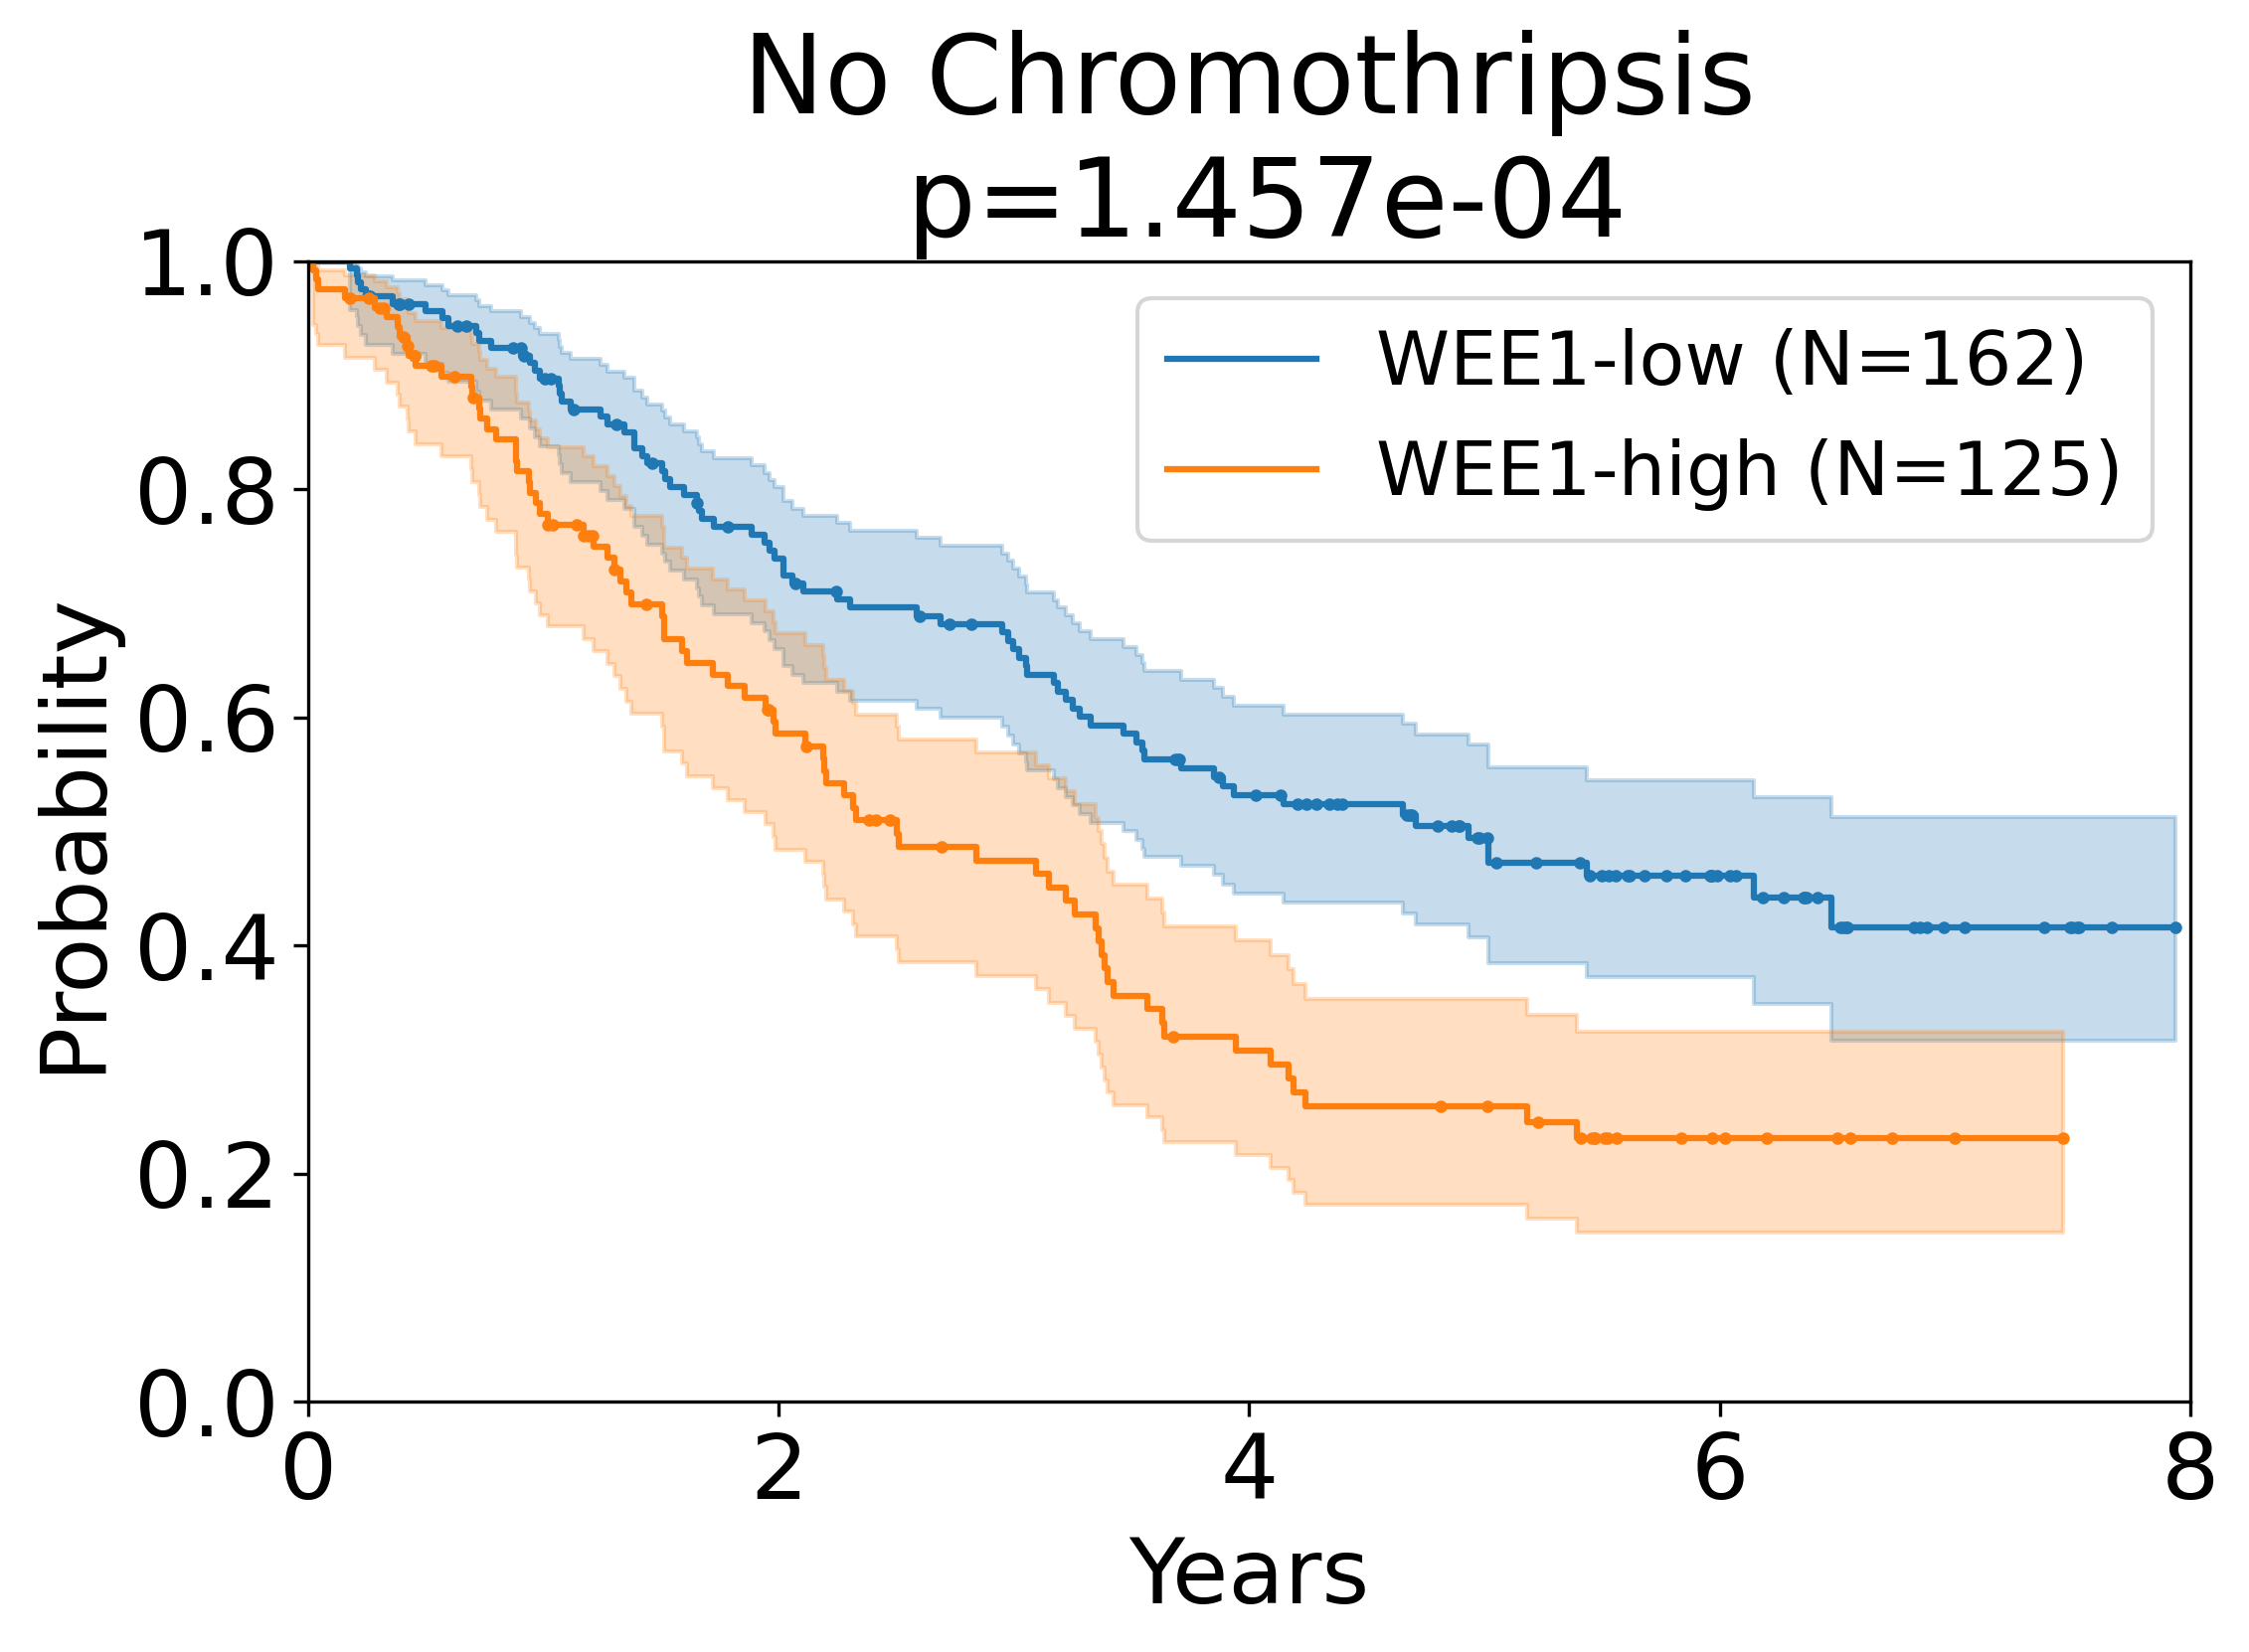

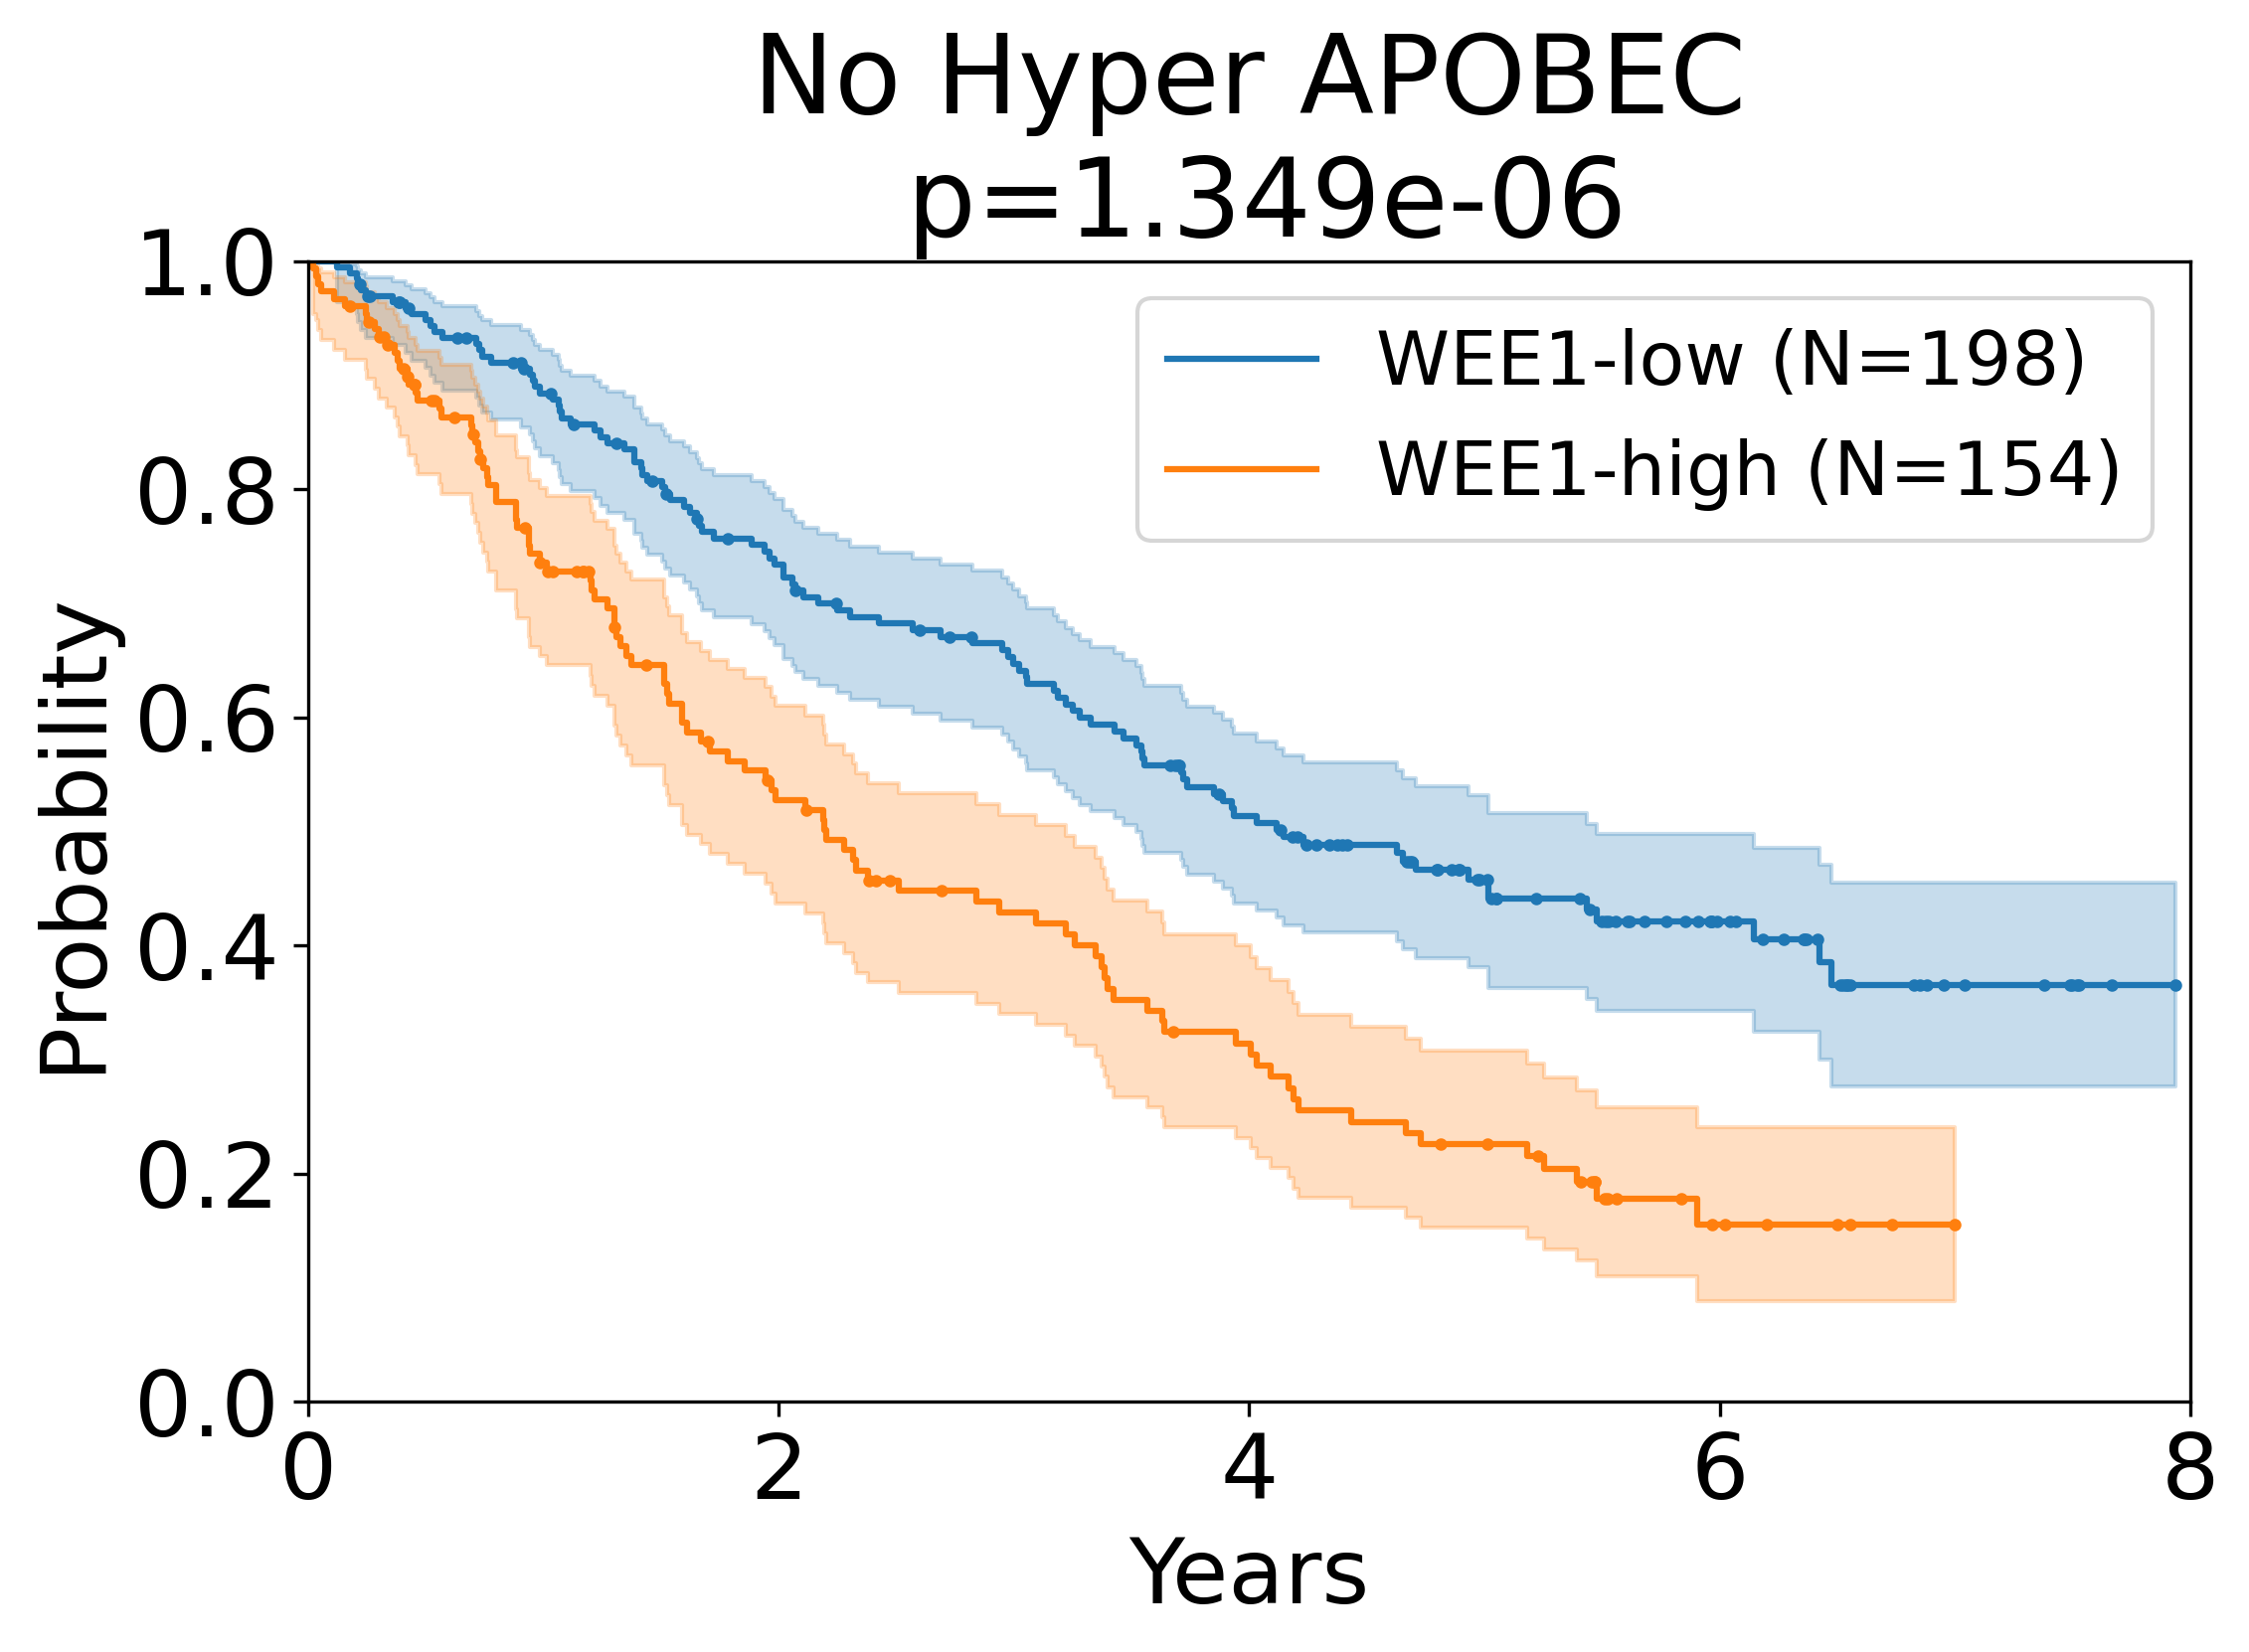

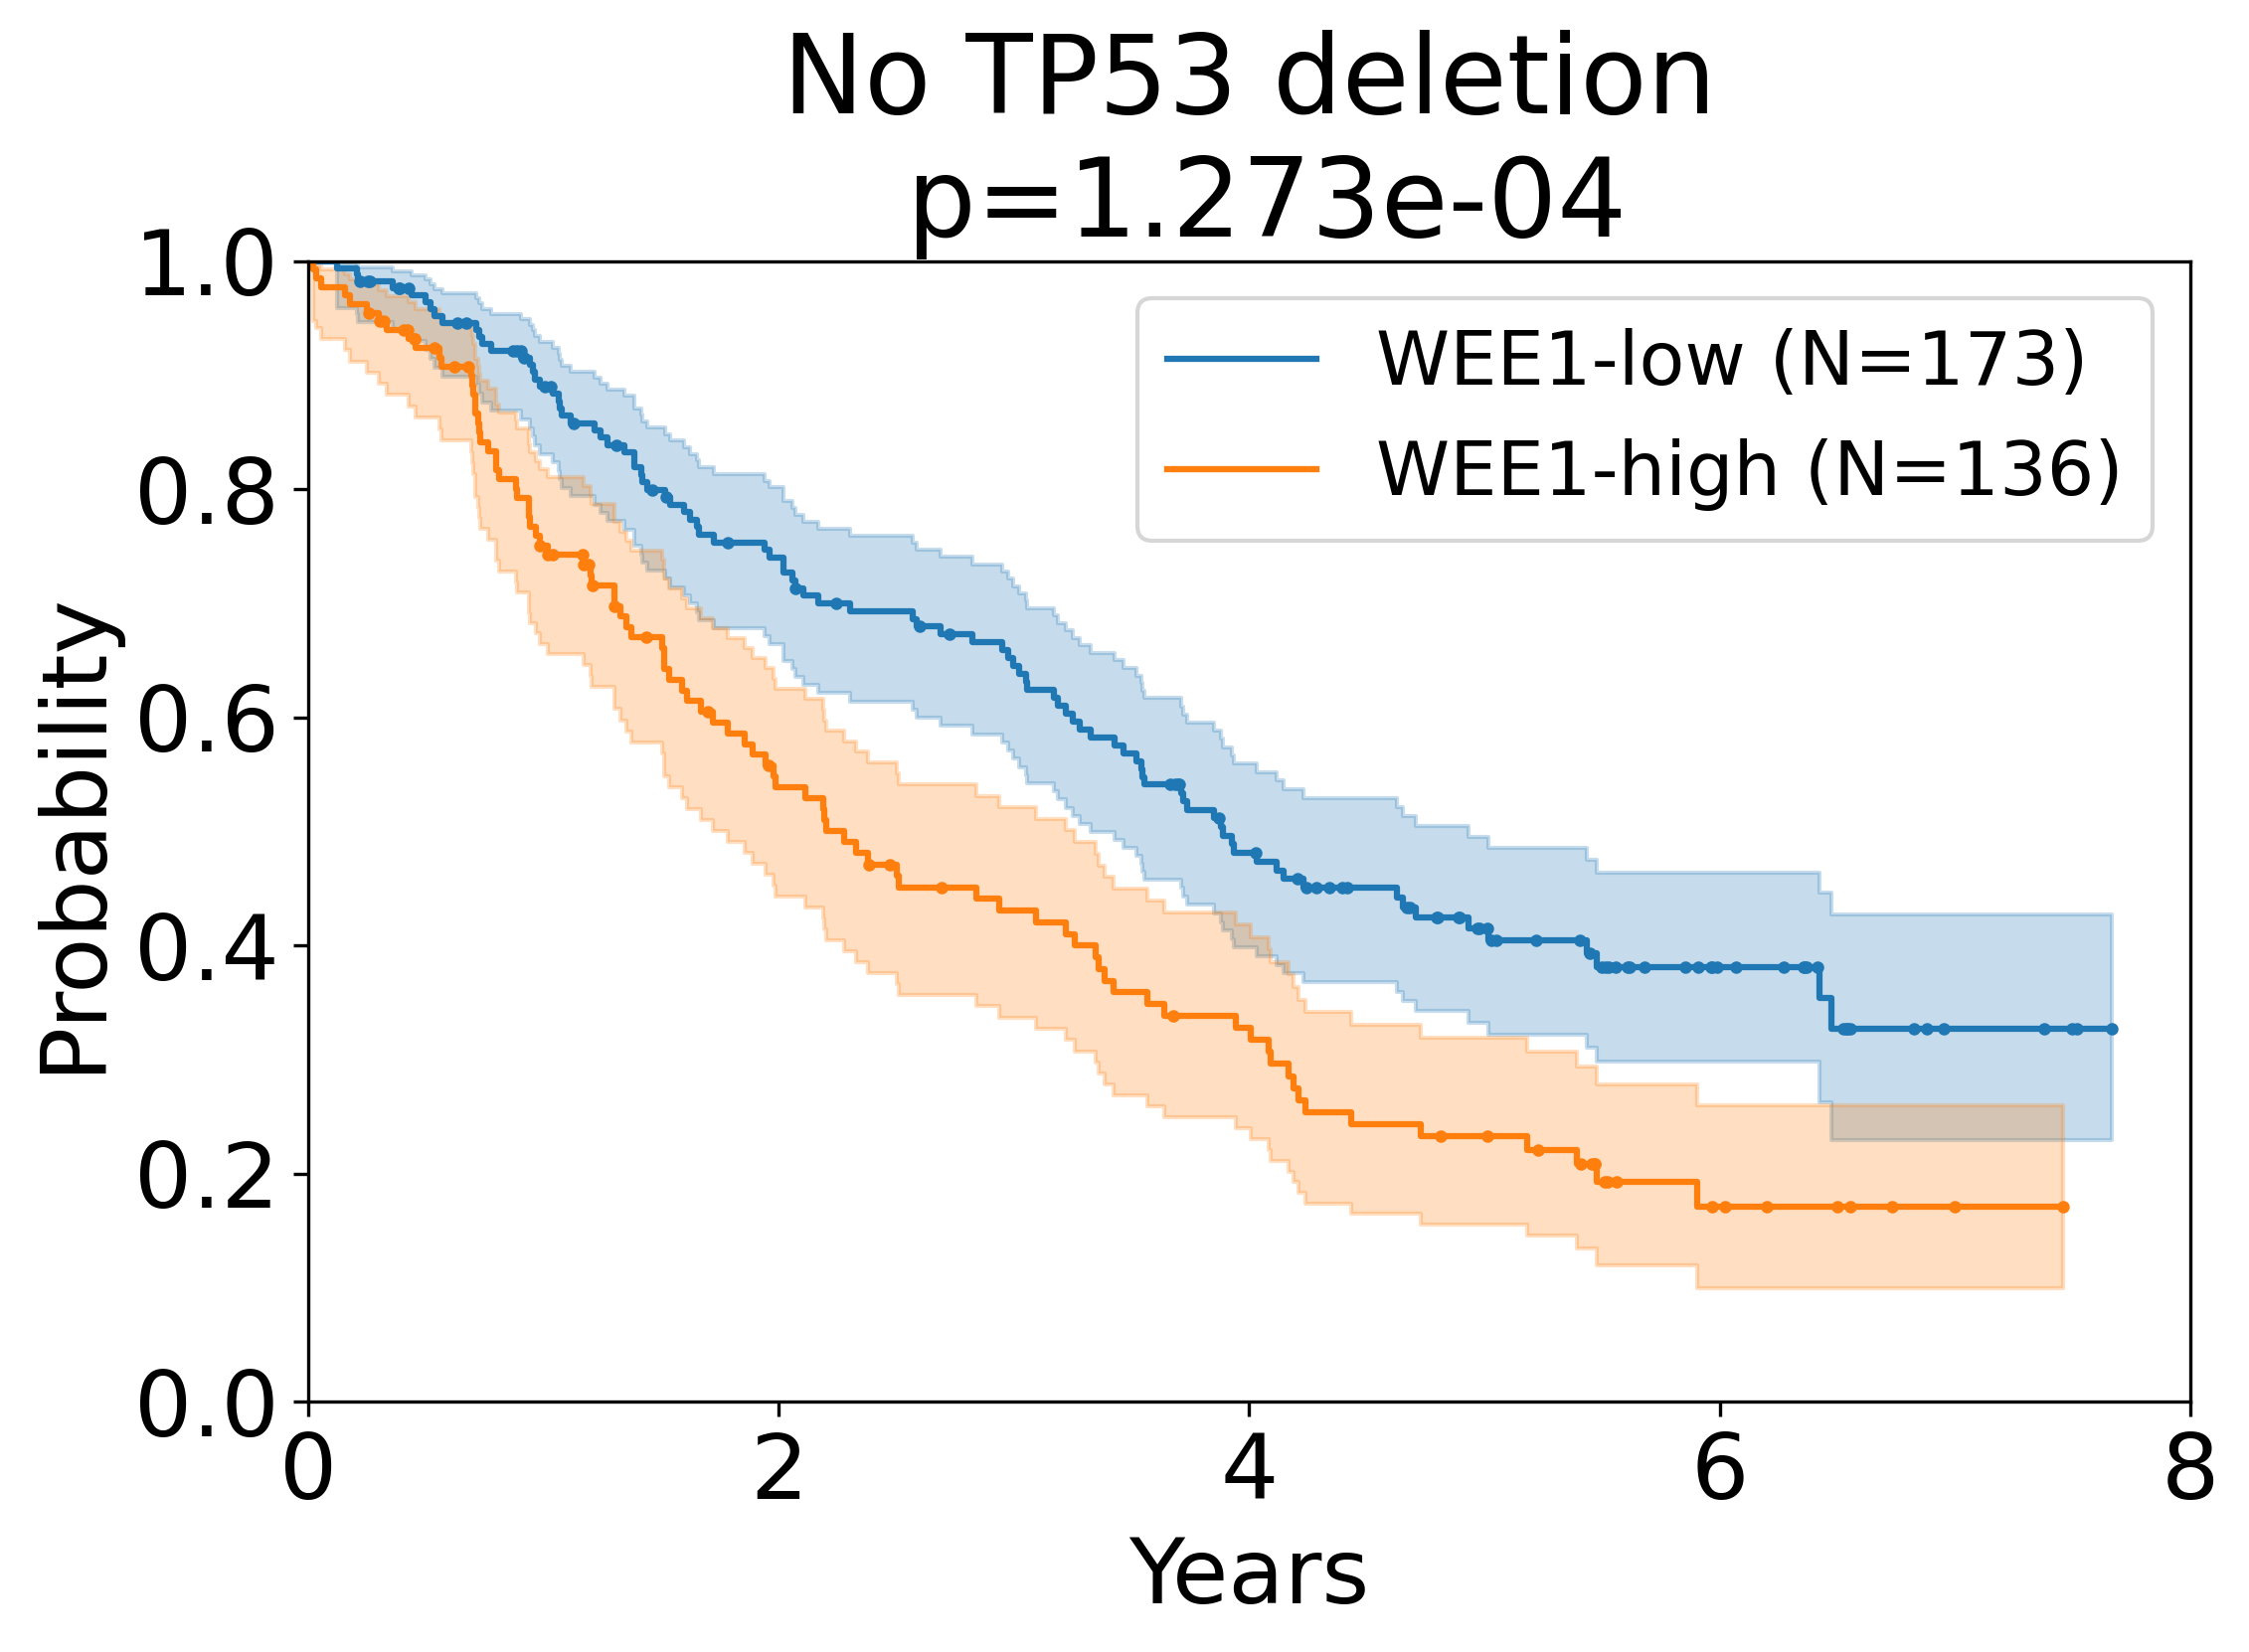

In [28]:
features_list = ['HRD', 't_MMSET', 't_CCND1', 'any_MAF',\
           't_MYC', 'chromothripsis_code', 'APOBEC_code',\
           'delTP53']

features_title_dict = {'HRD':'Hyperdiploidy', 't_MMSET':'t(4;14)',\
                       't_CCND1':'t(11;14)', 'any_MAF':'MAF translocation',\
                       't_MYC':'MYC translocation', 'chromothripsis_code':'Chromothripsis',\
                       'APOBEC_code':'Hyper APOBEC','delTP53':'TP53 deletion'}


wee1_text_labels = ['empty', 'low', 'high']
wee1_delta_list2 = [] 

for feature_name in features_list: 
    print('-------------') 
    print(feature_name) 

    feature_df = wee1_hi_lo_df[wee1_hi_lo_df[feature_name]==0]
    
    plt.figure(dpi=300, figsize=(8, 6))
    ax = plt.subplot(111)

    e_duration = feature_df['event_duration'].values
    w_labels = feature_df['wee1_labels'].values
    censor_list = feature_df['censorlist'].values
    
    output = multivariate_logrank_test(e_duration, w_labels, censor_list)
    
    kmf = KaplanMeierFitter()
    kmf_median_list = np.zeros(4)
    for ncluster in [1, 2]: 
        kmf.fit(e_duration[w_labels==ncluster],\
                censor_list[w_labels==ncluster],\
                label="WEE1-"+ wee1_text_labels[ncluster]+ " (N="+ str(sum(w_labels==ncluster)) +")")
        kmf.plot_survival_function(ax=ax,  show_censors=True,\
                                   censor_styles={'ms': 2, 'marker': 'o'}, ci_show=True)
        print(ncluster, np.round(kmf.median_survival_time_, 5), ' years')
        kmf_median_list[ncluster] = kmf.median_survival_time_
    plt.title('No ' + features_title_dict[feature_name] + "\n p=" + "{:.3e}".format(output.p_value))
    plt.xlabel('Years')
    plt.ylabel('Probability')

    wee1_delta_list2.append(kmf_median_list[1] - kmf_median_list[2])
    # print()
    plt.xlim(0, 8)
    plt.ylim(0, 1) 
    plt.rcParams.update({'font.size': 22})
    plt.legend(loc='upper right', fontsize="18")
    plt.tight_layout()
    
    # wee1_delta_list.append(kmf_median_list[1] - kmf_median_list[2])
    # print()
    plt.savefig('No_'+features_title_dict[feature_name] + '.png')


In [29]:
wee1_delta_list2

[2.684931506849315,
 2.4356164383561643,
 1.9561643835616438,
 1.9205479452054797,
 2.4356164383561643,
 2.4273972602739726,
 1.9424657534246577,
 1.6082191780821917]

In [30]:
delta_df = pd.DataFrame({'features_list':features_list, 'yes_delta':wee1_delta_list, 'no_delta':wee1_delta_list2, })

In [31]:
delta_df

,features_list,yes_delta,no_delta
0,HRD,1.838356,2.684932
1,t_MMSET,1.115068,2.435616
2,t_CCND1,inf,1.956164
3,any_MAF,inf,1.920548
4,t_MYC,2.120548,2.435616
5,chromothripsis_code,2.427397,2.427397
6,APOBEC_code,2.378082,1.942466
7,delTP53,inf,1.608219
